In [9]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sma
import warnings

In [11]:
#Setting Training and Test Sets
option_dict = {}
option_dict['ortho'] = False
option_dict['start_date'] = '1965-07-31'
option_dict['end_date'] = '2010-12-31'
option_dict['oos_date'] = '1985-07-31'
for key,value in option_dict.items():
    print(key,'\t',value)

ortho 	 False
start_date 	 1965-07-31
end_date 	 2010-12-31
oos_date 	 1985-07-31


In [29]:
# Ignore UserWarning related to header or footer parsing in Excel files
warnings.filterwarnings("ignore", message="Cannot parse header or footer so it will be ignored")
# Data preprocessing - WG_df
WG_df = pd.read_excel('PredictorData2020.xlsx', sheet_name='Monthly', header=0)
# Rename the column 'yyyymm' to 'date' for clarity
WG_df.rename(columns={'yyyymm': 'date'}, inplace=True)
# Convert the 'date' column to datetime format and set it to the month's end
WG_df['date'] = pd.to_datetime(WG_df['date'], format='%Y%m') + MonthEnd(0)
# Set 'date' as the DataFrame index
WG_df.set_index('date', drop=True, inplace=True)
# Filter data based on the provided date range in option_dict
WG_df = WG_df.loc[option_dict['start_date']:option_dict['end_date']]
# Calculate LogRx: log(1 + CRSP_SPvw) - log(1 + Rfree)
WG_df['LogRx'] = np.log1p(WG_df['CRSP_SPvw']) - np.log1p(WG_df['Rfree'])
# Calculate Rx: CRSP_SPvw - Rfree
WG_df['Rx'] = WG_df['CRSP_SPvw'] - WG_df['Rfree']
# Print the first 3 rows to check the processed data
print(WG_df.head(3))

            Index      D12      E12        BM     TBL     AAA     BAA     LTY  \
date                                                                            
1965-07-31  85.25  2.62667  4.88667  0.473382  0.0384  0.0448  0.0488  0.0424   
1965-08-31  87.17  2.64333  4.93333  0.467361  0.0384  0.0449  0.0488  0.0428   
1965-09-30  89.96  2.66000  4.98000  0.448537  0.0392  0.0452  0.0491  0.0433   

                NTIS   Rfree  ...        DP        DY        EP        DE  \
date                          ...                                           
1965-07-31  0.015627  0.0031  ... -3.479871 -3.466527 -2.859077 -0.620794   
1965-08-31  0.015601  0.0033  ... -3.495821 -3.473549 -2.871846 -0.623975   
1965-09-30  0.016895  0.0031  ... -3.521039 -3.489534 -2.893935 -0.627104   

               TMS     DFY     DFR        Rm     LogRx        Rx  
date                                                              
1965-07-31  0.0040  0.0040 -0.0402  4.442488  0.011287  0.011386  
1965-08

In [35]:
# Suppress warnings from openpyxl
warnings.filterwarnings("ignore", message="Unknown extension is not supported and will be removed")
# Data preprocessing - BW_df
BW_df = pd.read_excel('Investor_Sentiment_Data_20190327_POST.xlsx', sheet_name='DATA', header=0)
# Replace "." with NaN for missing values (without triggering the FutureWarning)
BW_df.replace(".", np.nan, regex=True, inplace=True)
# Explicitly convert object columns to their appropriate types to avoid the warning
BW_df = BW_df.apply(pd.to_numeric, errors='ignore')  # Convert columns to numeric where possible
# Rename the column 'yearmo' to 'date' for clarity
BW_df.rename(columns={'yearmo': 'date'}, inplace=True)
# Convert 'date' to datetime format and set it to the month's end
BW_df['date'] = pd.to_datetime(BW_df['date'], format='%Y%m') + MonthEnd(0)
# Filter data for dates between '1963-07-31' and '2010-12-31' and set 'date' as the index
BW_df = BW_df.query("'1963-07-31' <= date <= '2010-12-31'").set_index('date', drop=True)
# Calculate growth rates for industrial production, employment, and consumption
BW_df['gIndpro'] = BW_df['indpro'] / BW_df['indpro'].shift(12) - 1
BW_df['gEmploy'] = BW_df['employ'] / BW_df['employ'].shift(12) - 1
BW_df['gConsdur'] = (BW_df['consdur'] / BW_df['consdur'].shift(12)) / (BW_df['cpi'] / BW_df['cpi'].shift(12)) - 1
BW_df['gConsnon'] = (BW_df['consnon'] / BW_df['consnon'].shift(12)) / (BW_df['cpi'] / BW_df['cpi'].shift(12)) - 1
BW_df['gConsserv'] = (BW_df['consserv'] / BW_df['consserv'].shift(12)) / (BW_df['cpi'] / BW_df['cpi'].shift(12)) - 1
# Print the first 3 rows to verify
print(BW_df.head(3))

            SENT^   SENT       pdnd  ripo  nipo  cefd      eqti  Unnamed: 8  \
date                                                                          
1963-07-31     NaN   NaN  24.425216  -1.3   6.0   NaN  0.115720         NaN   
1963-08-31     NaN   NaN  24.067530   1.2   7.0   NaN  0.119039         NaN   
1963-09-30     NaN   NaN  23.696115   3.5   8.0   NaN  0.110274         NaN   

             indpro  consdur  consnon  consserv  recess  employ   cpi  \
date                                                                    
1963-07-31  27.7203     55.5    144.7     184.3       0   56794  30.7   
1963-08-31  27.7756     54.1    146.5     185.7       0   56910  30.7   
1963-09-30  28.0526     54.6    144.3     186.6       0   57078  30.7   

            gIndpro  gEmploy  gConsdur  gConsnon  gConsserv  
date                                                         
1963-07-31      NaN      NaN       NaN       NaN        NaN  
1963-08-31      NaN      NaN       NaN       NaN    

/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/513844862.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  BW_df.replace(".", np.nan, regex=True, inplace=True)
/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/513844862.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  BW_df = BW_df.apply(pd.to_numeric, errors='ignore')  # Convert columns to numeric where possible


In [37]:
# Extract relevant macroeconomic variables into a new DataFrame
Macro_df = BW_df[['gIndpro', 'gEmploy', 'gConsdur', 'gConsnon', 'gConsserv', 'recess']]
# Filter the macroeconomic variables for the date range 1965-07-31 to 2010-12-31
Macro1_df = Macro_df.loc['1965-07-31':'2010-12-31']
# Create a new DataFrame with macroeconomic variables lagged by 12 months
Macro2_df = Macro_df.shift(12).loc['1965-07-31':'2010-12-31']

In [39]:
# Create an empty DataFrame called BW_proxy_df
BW_proxy_df = pd.DataFrame(None)
# Negate the values of 'pdnd' and 'cefd' columns from BW_df and assign them to BW_proxy_df
BW_proxy_df[['pdnd', 'cefd']] = -BW_df[['pdnd', 'cefd']]
# Calculate the rolling sum over a 12-month window (with at least one data point) for the 'pdnd' column
BW_proxy_df['pdnd'] = BW_proxy_df['pdnd'].rolling(window=12, min_periods=1).sum()
# Calculate the rolling sum over a 12-month window (with at least one data point) for the 'cefd' column
BW_proxy_df['cefd'] = BW_proxy_df['cefd'].rolling(window=12, min_periods=1).sum()
# Calculate the rolling sum for the 'eqti' column from BW_df over a 12-month window
BW_proxy_df['eqti'] = BW_df['eqti'].rolling(window=12, min_periods=1).sum()
# Calculate the rolling sum for the 'nipo' column from BW_df over a 12-month window
BW_proxy_df['nipo'] = BW_df['nipo'].rolling(window=12, min_periods=1).sum()
# Compute a weighted rolling average for the 'ripo' column:
# (1) Multiply 'ripo' by 'nipo' from BW_df, then take the rolling sum
# (2) Divide the result by the rolling sum of 'nipo' (to normalize by total 'nipo')
BW_proxy_df['ripo'] = (BW_df['ripo'] * BW_df['nipo']).rolling(window=12, min_periods=1).sum() / \
    BW_df['nipo'].rolling(window=12, min_periods=1).sum()
# Shift the 'pdnd' and 'ripo' columns down by one row (lagging these values by one time period)
BW_proxy_df[['pdnd', 'ripo']] = BW_proxy_df[['pdnd', 'ripo']].shift()
# Filter the DataFrame to only include rows between the specified 'start_date' and 'end_date' from option_dict
BW_proxy_df = BW_proxy_df.loc[option_dict['start_date']:option_dict['end_date']]
# Print the first 5 rows of the resulting DataFrame (this line is commented out)
print(BW_proxy_df.head(5))

                  pdnd       cefd      eqti   nipo       ripo
date                                                         
1965-07-31 -343.926045 -19.274681  2.398778  124.0  11.974380
1965-08-31 -339.387566 -38.959852  2.320678  121.0  14.280645
1965-09-30 -333.817815 -56.536697  2.241562  130.0  16.422314
1965-10-31 -327.379547 -70.130848  2.150454  133.0  14.863077
1965-11-30 -318.181729 -84.091031  2.072099  145.0  13.959398


In [41]:
# Extract return data from WG_df for the columns 'LogRx' and 'Rx'
Ret_df = WG_df[['LogRx', 'Rx']]
# Define the target column name for the return data
Ret_target_name = 'LogRx'
# Extract the target return data ('LogRx') into a new DataFrame
target_R_df = Ret_df[[Ret_target_name]]
# Print the first 5 rows of the target return data (this line is commented out)
target_R_df.head(5)

,LogRx
date,
1965-07-31,0.011287
1965-08-31,0.023892
1965-09-30,0.029726
1965-10-31,0.025310
1965-11-30,-0.007322


In [45]:
# Select specific columns from BW_proxy_df and combine with Macro1_df
var1 = ['cefd', 'eqti', 'nipo']
BWvar1 = BW_proxy_df[var1]
BWvar1 = pd.concat([BWvar1, Macro1_df], axis=1)
# Select other specific columns from BW_proxy_df and combine with Macro2_df
var2 = ['pdnd', 'ripo']
BWvar2 = BW_proxy_df[var2]
BWvar2 = pd.concat([BWvar2, Macro2_df], axis=1)
# Combine selected columns from BWvar1 and BWvar2 into a single DataFrame
BWvar_df = pd.concat([BWvar1[var1], BWvar2[var2]], axis=1)
# Create an ExcelWriter object to save data into an Excel file
writer = pd.ExcelWriter('Sentiment data processing IS_OOS.xlsx', engine='openpyxl')
# Write each DataFrame to a separate sheet in the Excel file
BW_proxy_df.to_excel(writer, sheet_name='BW proxy')
Macro1_df.to_excel(writer, sheet_name='Macro1')
Macro2_df.to_excel(writer, sheet_name='Macro2')
Ret_df.to_excel(writer, sheet_name='Ret')
# Close the writer to save the file
writer.close()

In [47]:
BW_proxy_df = pd.read_excel('Sentiment data processing IS_OOS.xlsx', sheet_name = 'BW proxy')
BW_proxy_df['date'] = pd.to_datetime(BW_proxy_df['date'])
BW_proxy_df.set_index('date',drop=True, inplace=True)
#print(BW_proxy_df. head(3))

Macro1_df = pd.read_excel('Sentiment data processing IS_OOS.xlsx', sheet_name ='Macro1')
Macro1_df['date'] = pd.to_datetime(Macro1_df['date'])
Macro1_df.set_index('date',drop=True,inplace=True)
#print(Macro1_df.head(3))

Macro2_df = pd.read_excel('Sentiment data processing IS_OOS.xlsx', sheet_name ='Macro2')
Macro2_df['date'] = pd.to_datetime(Macro2_df['date'])
Macro2_df.set_index('date',drop=True,inplace=True)
#print(Macro2_df.head(3))

Ret_df = pd.read_excel('Sentiment data processing IS_OOS.xlsx', sheet_name ='Ret')
Ret_df['date'] = pd.to_datetime(Ret_df['date'])
Ret_df.set_index('date',drop=True,inplace=True)
#print(Ret_df.head(3))

In [49]:
var1 = ['cefd','eqti','nipo']
var2 = ['pdnd','ripo']
Ret_target_name = 'LogRx'
target_R_df = Ret_df[[Ret_target_name]]

BWvar1 = BW_proxy_df[var1]
BWvar1 = pd.concat([BWvar1, Macro1_df],axis=1)
#print(BWvar1.head(3))

BWvar2 = BW_proxy_df[var2]
BWvar2 = pd.concat( [BWvar2, Macro2_df], axis =1)
#print(BWvar2. head(3))

BWvar_df = pd.concat( [BWvar1[var1], BWvar2[var2]],axis=1)
#print(BWvar_df.head(3))
BWvar_df

,cefd,eqti,nipo,pdnd,ripo
date,,,,,
1965-07-31,-19.274681,2.398778,124,-343.926045,11.974380
1965-08-31,-38.959852,2.320678,121,-339.387566,14.280645
1965-09-30,-56.536697,2.241562,130,-333.817815,16.422314
1965-10-31,-70.130848,2.150454,133,-327.379547,14.863077
1965-11-30,-84.091031,2.072099,145,-318.181729,13.959398
...,...,...,...,...,...
2010-08-31,-109.910000,2.774998,154,40.464655,6.558042
2010-09-30,-108.200000,2.779832,157,43.210952,7.353247
2010-10-31,-104.520000,2.797755,169,48.020265,7.256688


In [51]:
Var_df = BWvar_df
Var_df = Var_df.apply(zscore,ddof=1)
target_R = target_R_df
#target_R
Reg_df = pd.concat([target_R.shift(-1), Var_df],axis =1)
Reg_df = Reg_df.iloc[:-1]
#Reg_df

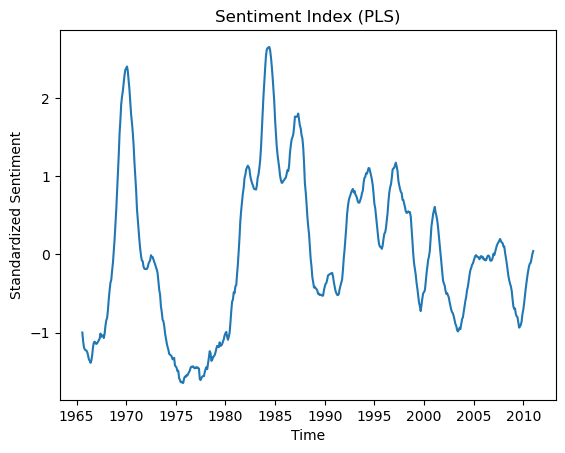

In [63]:
def PLS2step(target_R, Var_df, R_target_name):
    """
    Perform a two-step Partial Least Squares (PLS) regression to calculate a sentiment index.
    
    Parameters:
    - target_R: DataFrame containing the target variable (e.g., returns).
    - Var_df: DataFrame containing the independent variables (predictors).
    - R_target_name: Name of the target variable column in target_R.
    
    Returns:
    - PLS_df: A DataFrame containing the calculated sentiment index (standardized).
    """

    # Combine lagged target variable (shifted by -1) with predictors
    Reg_df = pd.concat([target_R.shift(-1), Var_df], axis=1)
    Reg_df = Reg_df.iloc[:-1]  # Drop the last row (to handle NaN after shifting)

    # Initialize dictionary to store first-step regression coefficients
    out = {}

    # First-step regression: Regress each predictor on the target variable
    for col in Var_df.columns:
        result = smf.ols(formula=f"{col} ~ {R_target_name}", data=Reg_df).fit(cov_type='HAC', cov_kwds={'maxlags': 0})
        out[col] = result.params.iloc[1]  # Use `.iloc` to explicitly access by position

    # Convert the collected coefficients into a DataFrame
    out_df = pd.DataFrame(out, columns=Var_df.columns, index=[0])

    # Initialize PLS DataFrame to store the sentiment index
    PLS_df = pd.DataFrame(None, index=Var_df.index, columns=['Sent'])

    # Second-step regression: Calculate the sentiment index for each time step
    for ind in Var_df.index:
        # Prepare data for regression (combine predictor values with first-step coefficients)
        data_df = pd.concat([Var_df.loc[ind].T, out_df.T], axis=1)
        data_df.columns = ['Y', 'X']
        
        # Perform regression for second step
        result = smf.ols(formula='Y ~ X', data=data_df).fit()
        
        # Use `.iloc` to access the intercept value explicitly
        PLS_df.loc[ind, 'Sent'] = result.params.iloc[0]  # Access intercept explicitly

    # Standardize the sentiment index (mean=0, std=1)
    PLS_df['Sent'] = (PLS_df['Sent'] - PLS_df['Sent'].mean()) / PLS_df['Sent'].std()

    return PLS_df

# Call the function to compute the sentiment index
SentiPLS_df = PLS2step(target_R, Var_df, Ret_target_name)

# Plot the sentiment index
plt.plot(SentiPLS_df)
plt.title("Sentiment Index (PLS)")
plt.xlabel("Time")
plt.ylabel("Standardized Sentiment")
plt.show()

# (Optional) Output the sentiment index to an Excel file
# SentiPLS_df.to_excel('PLS.xlsx')

In [65]:
def pls(xs, rm, standardize=True):
    """
    Partial Least Squares (PLS) two-stage regression for calculating a sentiment index.

    Parameters:
    - xs: ndarray, shape (T, N), represents T days and N sentiment indicators.
    - rm: ndarray, shape (T,) or (T, 1), represents T days of stock returns.
    - standardize: bool, whether to standardize the sentiment index (mean=0, std=1).

    Returns:
    - sent: ndarray, shape (T,), the calculated sentiment index as a one-dimensional array.
    """
    T, N = xs.shape  # T: number of days, N: number of sentiment indicators

    # Step 1: Regression of each sentiment indicator on stock returns (rm)
    pis = np.ones((N, 2))  # Coefficients for the first-stage regression, shape (N, 2)
    rm = sma.add_constant(rm)  # Add a constant term (intercept) to stock returns (rm)
    
    for n in range(N):
        # Use data up to T-1 for sentiment indicator (xs) and from day 1 onward for stock returns (rm)
        x = xs[:-1, n].ravel()  # Reshape the sentiment indicator to a 1D array
        r = rm[1:, :]  # Use stock returns from day 1 onward, shape (T-1, 2)
        
        # Perform regression: x ~ r (sentiment indicator ~ stock returns)
        result = sma.OLS(x, r).fit()
        pi = result.params[1]  # Extract the coefficient of the stock returns (rm)
        pis[n, 1] = pi  # Store the coefficient in pis[:, 1]

    # Step 2: Cross-sectional regression for sentiment index calculation
    ss = np.ones(T)  # Coefficients for the second-stage regression, shape (T,)
    
    for t in range(T):
        # Perform regression for each day t: sentiment indicators ~ coefficients from the first stage
        x = xs[t, :]  # Use sentiment indicators for day t, shape (N,)
        result = sma.OLS(x, pis).fit()
        ss[t] = result.params[1]  # Extract the coefficient for the sentiment index

    # Step 3: Standardize the sentiment index (if required)
    if standardize:
        sent = (ss - np.mean(ss)) / np.std(ss)  # Standardize to have mean=0 and std=1
    else:
        sent = ss

    # Return the calculated sentiment index as a 1D array
    return sent

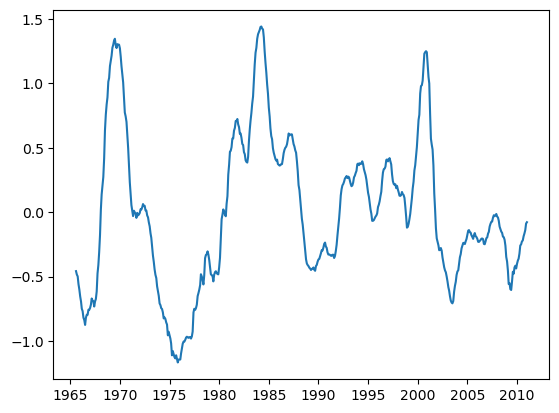

In [67]:
#EW
def EW_Senti(Var_df):
    #Var_df = Var_df.apply(zscore,ddof=1)
    #Var_df = pd.DataFrame(Var_df)
    cols = Var_df.columns
    Var_df['Sent'] = Var_df[cols].mean(axis=1)
    return Var_df[['Sent']] 
                   
Senti_dfEW = EW_Senti(Var_df)
plt.plot(Senti_dfEW)
#Senti_dfEW.to_excel('EW.xlsx')

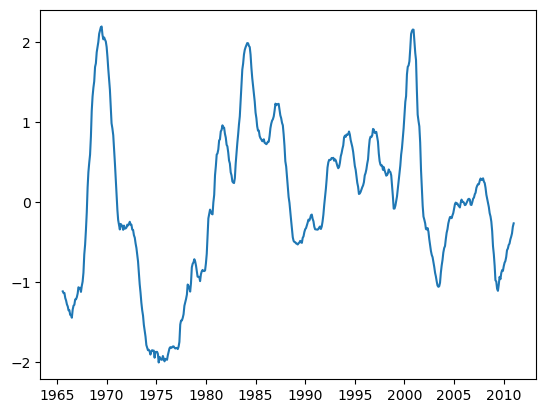

In [69]:
#BW
def BW_Senti(Var_df): 
    #Var_df = Var_df.apply(zscore,ddof=1) 
    #print(Var_df.head(10)) 
    pca =PCA(svd_solver='full') 
    score=pca.fit_transform(Var_df)
    #print(score)
    Var_df ['Sent']=zscore(score[:,0]) 
    return Var_df[['Sent']] 

SentiBW_df=BW_Senti(Var_df)
plt.plot(SentiBW_df)
#SentiBW_df.to_excel('BW.xlsx')

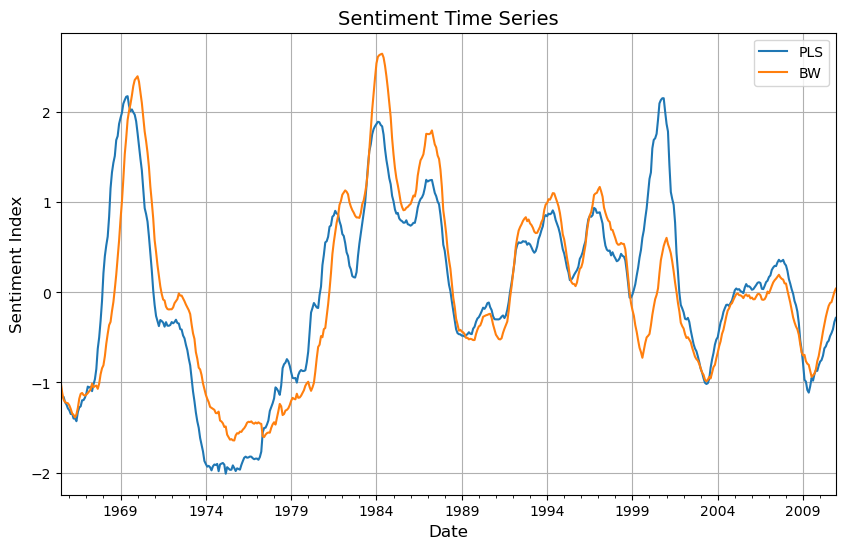

In [73]:
#Figure 1
# Load data from Excel
sentiment_df = pd.read_excel('data1.xlsx', sheet_name='Monthly', header=0)

# Rename the date column
sentiment_df.rename(columns={'yyyymm': 'date'}, inplace=True)

# Convert the date column to datetime format and set as index
try:
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], format='%Y%m') + MonthEnd(0)
    sentiment_df.set_index('date', drop=True, inplace=True)
except Exception as e:
    print("Error in date conversion:", e)

# Plot the selected columns (18th and 19th)
try:
    sentiment_df.iloc[:, 18:20].dropna().plot(figsize=(10, 6))
    plt.title('Sentiment Time Series', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sentiment Index', fontsize=12)
    plt.legend(['PLS', 'BW'], fontsize=10)
    plt.grid(True)
    plt.show()
except Exception as e:
    print("Error in plotting:", e)

In [75]:
#Table 1 DescriptiveStatistics
data = sentiment_df.copy()
data = data.select_dtypes(include=[np.number])
# Descriptive statistics
table1 = data.describe()
# Compute skewness and kurtosis
s = data.skew()
k = data.kurt()
# Add skewness and kurtosis as rows in the descriptive statistics table
table1.loc['skew'] = s
table1.loc['kurtosis'] = k
# Round the results for better readability
table1 = table1.round(2)
# Print the table for confirmation
print(table1)

             TBL     LTY    NTIS    INFL     LTR    SVAR      DP      DY  \
count     546.00  546.00  546.00  546.00  546.00  546.00  546.00  546.00   
mean        0.05    0.07    0.01    0.00    0.01    0.00   -3.56   -3.56   
std         0.03    0.02    0.02    0.00    0.03    0.00    0.42    0.42   
min         0.00    0.03   -0.06   -0.02   -0.11    0.00   -4.52   -4.53   
25%         0.04    0.05    0.00    0.00   -0.01    0.00   -3.93   -3.93   
50%         0.05    0.07    0.01    0.00    0.01    0.00   -3.49   -3.49   
75%         0.07    0.08    0.03    0.01    0.02    0.00   -3.27   -3.26   
max         0.16    0.15    0.05    0.02    0.15    0.07   -2.75   -2.75   
skew        0.72    0.90   -0.83   -0.13    0.40    9.88   -0.37   -0.38   
kurtosis    1.35    0.36    0.79    3.91    2.58  122.52   -0.76   -0.74   

              EP      DE     TMS     DFY     DFR      Rf      Rm     CAY  \
count     546.00  546.00  546.00  546.00  546.00  546.00  546.00  546.00   
mean       

In [103]:
def signif(result, pos):
    """
    Formats the beta coefficient with significance stars based on p-values.
    """
    pvalue = result.pvalues.iloc[pos]  # Use .iloc to access p-value by position
    beta = result.params.iloc[pos] * 100  # Use .iloc to access beta by position
    beta = round(beta, 2)  # Round to 2 decimal places
    if pvalue < 0.01:
        return f"{beta}***"
    elif pvalue < 0.05:
        return f"{beta}**"
    elif pvalue < 0.1:
        return f"{beta}*"
    else:
        return str(beta)

In [111]:
#Defining the R2 function
def R2c(y,result,dummy):
    """
    Calculates R-squared for a filtered subset of data (e.g., recession/expansion).
    """
    resid=result.resid.values
    if resid.size<500:
        y=y[y.size-resid.size:]
    r1=(resid**2)*dummy
    r2=((y-y.mean())**2)*dummy
    R2=1-r1.sum()/r2.sum()
    return round(R2*100,2)

In [113]:
#Table 2 In-sample forecasts
# Load the dataset
table_2_df = pd.read_excel('data2.xlsx', header=0, index_col=0)

# Select sentiment indicators, market returns, and recession indicator
df_sent = table_2_df[['PDND', 'CEFD', 'EQTI', 'NIPO', 'RIPO', 'BW', 'PLS', 'PLS_F', 'EW']]
df_ret = table_2_df[['Rm']]
df_rec = table_2_df[['Recess']]

# List of sentiment indicators for regression
sents = ['CEFD', 'NIPO', 'RIPO', 'PDND', 'EQTI', 'BW', 'EW', 'PLS', 'PLS_F', 'Kitchen sink']

# Lag sentiment indicators by one period
df1 = df_sent.shift(1)  # Shift all sentiment indicators by 1 period

# Merge lagged sentiment indicators with market returns
df_ols2 = df1.merge(df_ret, left_index=True, right_index=True)

# Drop a specific problematic index if it exists
if 196507 in df_ols2.index:
    df_ols2.drop(index=196507, inplace=True)

# Define the dependent variable (market returns)
y = df_ols2['Rm']

# Initialize lists to store regression results
results = []  # Regression model results
betas = []  # Coefficients (beta) for each sentiment indicator
ts = []  # t-statistics for each sentiment indicator
R2s = []  # R-squared values for each regression

# Perform OLS regression for each sentiment indicator
for sent in sents:
    if sent == 'Kitchen sink':  # Use multiple indicators in one model
        x = sma.add_constant(df_ols2.loc[:, sents[0:5]])  # Use the first 5 indicators
    else:
        x = sma.add_constant(df_ols2[sent])  # Use a single indicator

    # Build and fit the OLS regression model
    model = sma.OLS(y, x, missing='drop')
    result = model.fit()

    # Extract beta (coefficient) with significance stars
    if sent == 'Kitchen sink':
        beta = ''  # Skip beta for "Kitchen sink"
    else:
        beta = signif(result, 1)  # Format beta with significance stars

    # Extract t-statistic
    if sent == 'Kitchen sink':
        t = ''  # Skip t-statistic for "Kitchen sink"
    else:
        t = round(result.tvalues.iloc[1], 2)  # Use .iloc to access by position

    # Extract R-squared value as a percentage
    R2 = round(result.rsquared * 100, 2)

    # Append results to lists
    results.append(result)
    betas.append(beta)
    ts.append(t)
    R2s.append(R2)

# Create a DataFrame to store regression results
table2 = pd.DataFrame(
    index=sents,
    columns=['beta(%)', 't-stat', 'R2(%)', 'R2_up(%)', 'R2_down(%)', 'R2_high(%)', 'R2_low(%)']
)
table2['beta(%)'] = betas  # Add beta coefficients
table2['t-stat'] = ts  # Add t-statistics
table2['R2(%)'] = R2s  # Add R-squared values

# Merge recession indicator (lagged by one period) with regression dataset
df_ols3 = df_ols2.merge(df_rec.shift(1), left_index=True, right_index=True)

# Define variables for recession and expansion periods
rec_down = df_ols3['Recess'].values  # Recession periods
rec_up = rec_down + 1  # Expansion periods
rec_up[rec_up == 2] = 0  # Ensure binary values (0 for expansion, 1 for recession)

# Initialize lists for R-squared values during different periods
R2_ups = []  # R-squared during expansion periods
R2_downs = []  # R-squared during recession periods

# Define variables for high and low sentiment periods
nlen = df_ols3['PLS_F'].isnull().sum()  # Number of missing values for PLS_F
sent = df_ols3['PLS']  # Use PLS as the sentiment index
sent_me = sent.median()  # Median sentiment as threshold
sent_high = np.array(sent >= sent_me)  # High sentiment periods
sent_low = np.array(sent < sent_me)  # Low sentiment periods

R2_highs = []  # R-squared during high sentiment periods
R2_lows = []  # R-squared during low sentiment periods

# Calculate R-squared values for different periods
for result in results:
    # Adjust for shorter sample size for PLS_F
    if results.index(result) == len(results) - 2:  # Second-to-last result
        rec_up1 = rec_up[nlen:]  # Adjust expansion period array
        rec_down1 = rec_down[nlen:]  # Adjust recession period array
        sent_high1 = sent_high[nlen:]  # Adjust high sentiment array
        sent_low1 = sent_low[nlen:]  # Adjust low sentiment array
    else:
        rec_up1 = rec_up
        rec_down1 = rec_down
        sent_high1 = sent_high
        sent_low1 = sent_low

    # Calculate R-squared for each period
    R2_up = R2c(y, result, rec_up1)  # Expansion period
    R2_down = R2c(y, result, rec_down1)  # Recession period
    R2_high = R2c(y, result, sent_high1)  # High sentiment period
    R2_low = R2c(y, result, sent_low1)  # Low sentiment period

    # Append R-squared values to lists
    R2_ups.append(R2_up)
    R2_downs.append(R2_down)
    R2_highs.append(R2_high)
    R2_lows.append(R2_low)

# Add R-squared values for different periods to the results table
table2['R2_up(%)'] = R2_ups  # Expansion
table2['R2_down(%)'] = R2_downs  # Recession
table2['R2_high(%)'] = R2_highs  # High sentiment
table2['R2_low(%)'] = R2_lows  # Low sentiment

# Print the results table
pd.set_option('display.width', 1000)  # Adjust display width for better readability
print(table2)  # Print the final table

               beta(%) t-stat  R2(%)  R2_up(%)  R2_down(%)  R2_high(%)  R2_low(%)
CEFD             -0.08  -0.43   0.03      0.01        0.10        0.04       0.02
NIPO              0.02   0.09   0.00      0.00        0.00        0.01      -0.01
RIPO            -0.32*   -1.7   0.53      0.62        0.29        0.58       0.44
PDND             -0.03  -0.14   0.00      0.01       -0.02       -0.01       0.03
EQTI             -0.11  -0.58   0.06      0.13       -0.10        0.03       0.11
BW               -0.17  -0.96   0.17      0.19        0.13        0.11       0.25
EW               -0.29  -0.92   0.16      0.21        0.01        0.06       0.30
PLS           -0.67***  -3.57   2.30      2.03        2.96        2.50       2.00
PLS_F            -0.14  -0.65   0.10     -0.07        0.64        0.10       0.10
Kitchen sink                    1.04      0.99        1.15        1.28       0.68


In [115]:
#Table 3 Predictions including tests
# Import the necessary function for the t-test
from scipy.stats import t  # Import t-distribution for the MDM test

# Define the MDM test function
def MDM(result1, result2):
    """
    Perform the Modified Diebold-Mariano (MDM) test to compare two models.
    
    Parameters:
    - result1: The first regression result (statsmodels OLS result object).
    - result2: The second regression result (statsmodels OLS result object).
    
    Returns:
    - pvalue: The one-tailed p-value of the MDM test (rounded to 2 decimal places).
    """
    # Calculate residuals (errors) for both models
    e1 = result1.resid
    e2 = result2.resid
    
    # Compute the difference-in-residuals term
    d = (e1 - e2) * e1  # Weighted residuals based on the first model's residuals
    
    # Calculate the MDM statistic
    dm = d.mean() / d.std()  # Mean divided by standard deviation of d
    n = result1.nobs  # Number of observations in the first model
    mdm = (((n - 1) / n) ** 0.5) * dm  # MDM statistic as per the formula in the paper
    
    # Compute the p-value using the t-distribution
    pvalue = t.sf(mdm, n - 1)  # Survival function (1-CDF) for a one-tailed test
    
    return round(pvalue, 2)  # Return the p-value rounded to 2 decimal places


# Generate Table 3: Pairwise comparison of predictive power
table3 = pd.DataFrame(index=sents[:-2], columns=sents[:-2])  # Exclude the last two variables ('PLS_F' and 'Kitchen sink')

# Use the regression results from Table 2
results = results[:-2][:]  # Exclude the last two models (e.g., 'PLS_F' and 'Kitchen sink')

# Perform pairwise comparisons of predictive power
for i in range(len(results)):
    result2s = results[:]  # Create a copy of the results list
    result1 = result2s.pop(i)  # Remove the i-th model (self-comparison is not allowed)
    pvalues = []  # Initialize a list to store p-values
    
    # Compare the i-th model with all other models
    for result2 in result2s:
        pvalue = MDM(result1, result2)  # Perform the MDM test
        pvalues.append(pvalue)  # Append the p-value to the list
    
    # Insert a blank space (' ') in the diagonal (self-comparison)
    pvalues.insert(i, ' ')
    
    # Assign the p-values to the i-th row of the table
    table3.iloc[i, :] = pvalues

# Save the table to an Excel file (optional)
# table3.to_excel('Table3.xlsx')

# Print Table 3
print(table3)  # Display the comparison table for predictive power

      CEFD NIPO  RIPO PDND  EQTI    BW    EW   PLS
CEFD        0.5  0.47  0.5  0.49  0.49  0.49  0.44
NIPO  0.49       0.47  0.5  0.49  0.49  0.49  0.44
RIPO   0.5  0.5        0.5   0.5   0.5   0.5  0.45
PDND  0.49  0.5  0.47       0.49  0.49  0.48  0.44
EQTI  0.49  0.5  0.47  0.5        0.49  0.49  0.44
BW     0.5  0.5  0.48  0.5   0.5         0.5  0.44
EW     0.5  0.5  0.48  0.5   0.5   0.5        0.44
PLS    0.5  0.5  0.48  0.5   0.5   0.5   0.5      


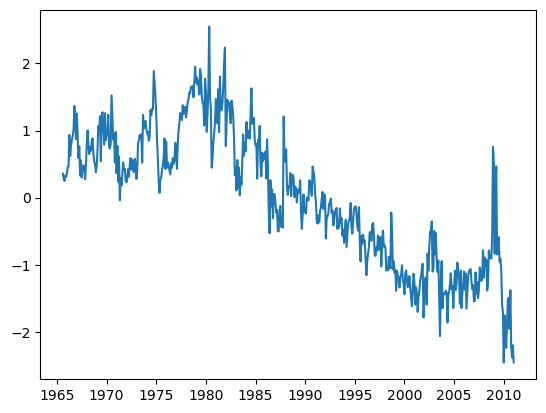

In [117]:
df_econ = pd.read_excel('ECON.xlsx',header = 0,index_col=0)
df_econ = df_econ.apply(zscore,ddof=1)
#df_econ
df_ols4=df_ols2.loc[:,['Rm','PLS']].merge(df_econ.shift(1),left_index=True,right_index=True)
y=df_ols4['Rm']

#构造ECON_PC预测指标，这里采用主成分分析方法
econs=df_ols4.loc[:,df_econ.columns].values
model=PCA(n_components=1,whiten=True)
model.fit(econs)
df_ols4['ECON_PC']=model.transform(econs)
#df_ols4.to_excel('df_ols4.xlsx')
#df_ols4.xlsx包含ECON_PC

#构造ECON_PLS预测指标，这里采用PLS方法
df_econ1 = pd.read_excel('ECON.xlsx',header = 0)
df_econ1.rename(columns = {'yyyymm':'date'},inplace = True)
df_econ1['date'] = pd.to_datetime(df_econ1['date'],format = '%Y%m') + MonthEnd(0)
df_econ1.set_index('date',drop=True,inplace=True)
SentiPLS1_df = PLS2step(target_R,df_econ1,Ret_target_name)
plt.plot(SentiPLS1_df)
#SentiPLS1_df.to_excel('ECON_PLS.xlsx')
#ECON_PLS.xlsx包含ECON_PLS

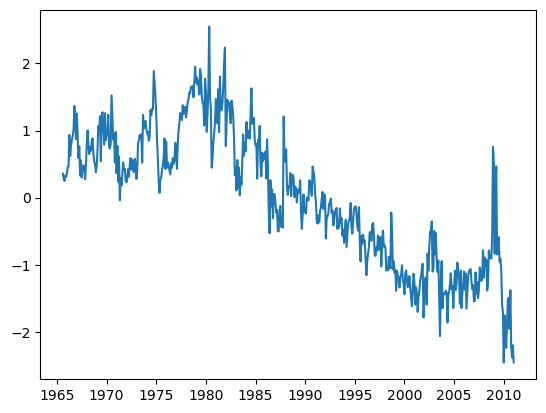

In [119]:
# Load economic data from an Excel file
df_econ = pd.read_excel('ECON.xlsx', header=0, index_col=0)

# Standardize the economic data using z-scores
# The zscore function standardizes each column (mean=0, std=1)
df_econ = df_econ.apply(zscore, ddof=1)

# Merge the lagged economic data and the sentiment index (PLS) with stock returns (Rm)
df_ols4 = df_ols2.loc[:, ['Rm', 'PLS']].merge(df_econ.shift(1), left_index=True, right_index=True)

# Define the dependent variable (stock returns)
y = df_ols4['Rm']

# Construct the ECON_PC predictor using Principal Component Analysis (PCA)
econs = df_ols4.loc[:, df_econ.columns].values  # Extract economic variables as a NumPy array
model = PCA(n_components=1, whiten=True)  # Initialize PCA with 1 component and whitening enabled
model.fit(econs)  # Fit the PCA model to the economic data
df_ols4['ECON_PC'] = model.transform(econs)  # Transform the data and add the first principal component to the DataFrame

# Optional: Save the resulting DataFrame to an Excel file for inspection
# df_ols4.to_excel('df_ols4.xlsx') 
# The saved file will include the derived ECON_PC variable.

# Construct the ECON_PLS predictor using the Partial Least Squares (PLS) method
# Reload the economic data for PLS processing
df_econ1 = pd.read_excel('ECON.xlsx', header=0)

# Rename the date column for consistency
df_econ1.rename(columns={'yyyymm': 'date'}, inplace=True)

# Convert the 'date' column to a proper datetime format (YYYY-MM) and set it as the index
df_econ1['date'] = pd.to_datetime(df_econ1['date'], format='%Y%m') + MonthEnd(0)
df_econ1.set_index('date', drop=True, inplace=True)

# Use the custom-defined PLS2step function to compute the ECON_PLS predictor
# target_R: The target variable (e.g., stock returns)
# df_econ1: The economic data
# Ret_target_name: Name of the returns column in df_econ1
SentiPLS1_df = PLS2step(target_R, df_econ1, Ret_target_name)

# Plot the ECON_PLS predictor for visualization
plt.plot(SentiPLS1_df)

# Optional: Save the resulting ECON_PLS predictor to an Excel file
# SentiPLS1_df.to_excel('ECON_PLS.xlsx') 
# The saved file will include the derived ECON_PLS variable.

In [121]:
#Table 4A Univariate Prediction Regression Compared with Economic Variables
# Load the dataset from an Excel file
df_ols4 = pd.read_excel('data3.xlsx', header=0, index_col=0)

# Initialize lists to store regression results
psis = []  # Stores the coefficients (psi) of each economic indicator
ts = []  # Stores the t-statistics of each economic indicator
R2s = []  # Stores the R² values for each regression

# Define the economic predictors (columns starting from the 3rd column onward in df_ols4)
econ_pre = df_ols4.columns[2:]

# Define the dependent variable (market returns) - ensure `y` is properly defined
y = df_ols4['Rm']  # Replace 'Rm' with the name of your dependent variable if different

# Loop through each economic indicator and perform OLS regression
for econ in econ_pre:
    # Add a constant term (intercept) to the independent variable
    x = sma.add_constant(df_ols4[econ])  # Economic indicator as the independent variable
    
    # Build the OLS regression model
    model = sma.OLS(y, x, missing='drop')  # y is the dependent variable
    result = model.fit()  # Fit the OLS model
    
    # Extract the coefficient and significance for the economic indicator
    psi = signif(result, 1)  # Use the `signif` function to format the coefficient
    t = round(result.tvalues.iloc[1], 2)  # Use .iloc to extract the t-statistic by position
    R2 = round(result.rsquared * 100, 2)  # Calculate R² value and convert to a percentage
    
    # Append the results to the corresponding lists
    psis.append(psi)  # Append the coefficient with significance
    ts.append(t)  # Append t-statistic
    R2s.append(R2)  # Append R² value

# Create a DataFrame to store the results for Panel A of Table 4
table4A = pd.DataFrame(index=econ_pre, columns=['psi(%)', 't-stat', 'R2(%)'])
table4A['psi(%)'] = psis  # Add the coefficients to the table
table4A['t-stat'] = ts  # Add the t-statistics to the table
table4A['R2(%)'] = R2s  # Add the R² values to the table

# Save the results to an Excel file
table4A.to_excel('Table4A.xlsx')  # Export Table 4 Panel A to an Excel file

# Optional: Save the full data (df_ols4) to an Excel file for inspection
# df_ols4.to_excel('OLS4.xlsx')

# Print the results table for quick inspection
print(table4A)  # Display Table 4 Panel A

             psi(%)  t-stat  R2(%)
DP             0.21    1.09   0.22
DY             0.24    1.23   0.28
EP             0.11    0.55   0.06
DE             0.12    0.62   0.07
SVAR       -0.49***   -2.59   1.22
NTIS          -0.07   -0.36   0.02
TBL           -0.19   -0.96   0.17
LTY            -0.0   -0.01   0.00
LTR          0.47**    2.46   1.10
TMS           0.35*    1.82   0.61
DFY            0.22    1.15   0.25
DFR           0.37*    1.94   0.69
INFL          -0.31   -1.61   0.47
CAY            0.08    0.42   0.03
CSR            -0.1   -0.50   0.05
OG         -0.55***   -2.89   1.51
ECON_PC        0.02    0.12   0.00
ECON_PLS    -0.42**   -2.19   0.88
SECON_PC       0.01    0.07   0.00
SECON_PLS      -0.1   -0.53   0.05


In [123]:
# Define the `signif` function to format coefficients with significance stars
def signif(result, pos):
    """
    Formats the coefficient with significance stars based on p-values.
    """
    pvalue = result.pvalues.iloc[pos]  # Use .iloc to access p-value by position
    coef = result.params.iloc[pos] * 100  # Use .iloc to access coefficient by position
    coef = round(coef, 2)  # Round to 2 decimal places
    if pvalue < 0.01:
        return f"{coef}***"
    elif pvalue < 0.05:
        return f"{coef}**"
    elif pvalue < 0.1:
        return f"{coef}*"
    else:
        return str(coef)

# Initialize lists to store regression results
betas = []  # Coefficients for the sentiment indicator (PLS)
tbs = []  # t-statistics for the sentiment indicator (PLS)
psis = []  # Coefficients for the economic indicator
tps = []  # t-statistics for the economic indicator
R2s = []  # R-squared values

# Loop through each economic indicator and perform bivariate OLS regression
for econ in econ_pre:
    # Select the independent variables (PLS and the current economic indicator)
    x = df_ols4.loc[:, ['PLS', econ]]
    x = sma.add_constant(x)  # Add a constant term (intercept)
    
    # Build and fit the OLS regression model
    model = sma.OLS(y, x, missing='drop')
    result = model.fit()
    
    # Extract coefficients and significance stars
    beta = signif(result, 1)  # Coefficient for the sentiment indicator (PLS)
    tb = round(result.tvalues.iloc[1], 2)  # t-statistic for the sentiment indicator (PLS)
    psi = signif(result, 2)  # Coefficient for the economic indicator
    tp = round(result.tvalues.iloc[2], 2)  # t-statistic for the economic indicator
    R2 = round(result.rsquared * 100, 2)  # R-squared value, converted to a percentage
    
    # Append results to the corresponding lists
    betas.append(beta)
    tbs.append(tb)
    psis.append(psi)
    tps.append(tp)
    R2s.append(R2)

# Create a DataFrame to store the results for Panel B of Table 4
table4B = pd.DataFrame(index=econ_pre, columns=['beta(%)', 't-stat', 'psi(%)', 't-stat', 'R2(%)'])
table4B['beta(%)'] = betas  # Add sentiment indicator coefficients
table4B.iloc[:, 1] = tbs  # Add t-statistics for the sentiment indicator
table4B['psi(%)'] = psis  # Add economic indicator coefficients
table4B.iloc[:, 3] = tps  # Add t-statistics for the economic indicator
table4B['R2(%)'] = R2s  # Add R-squared values

# Drop unwanted rows (e.g., 'SECON_PC' and 'SECON_PLS') if they exist
if 'SECON_PC' in table4B.index and 'SECON_PLS' in table4B.index:
    table4B = table4B.drop(['SECON_PC', 'SECON_PLS'], axis=0)

# Save the table to an Excel file (optional)
# table4B.to_excel('Table4B.xlsx')

# Print the results table for quick inspection
print(table4B)

           beta(%) t-stat    psi(%) t-stat  R2(%)
DP        -0.76***  -3.95     0.36*   1.88   3.01
DY        -0.76***  -3.95    0.38**   1.97   3.07
EP         -0.7***  -3.68      0.16   0.83   2.50
DE        -0.72***  -3.78      0.23    1.2   2.64
SVAR       -0.7***   -3.7  -0.51***  -2.68   3.66
NTIS      -0.69***  -3.61      0.02   0.09   2.38
TBL       -0.68***  -3.54      -0.1  -0.53   2.43
LTY       -0.71***  -3.68      0.11   0.59   2.44
LTR       -0.69***  -3.65    0.47**   2.49   3.48
TMS        -0.7***  -3.68     0.36*   1.91   3.03
DFY       -0.72***  -3.77      0.29   1.52   2.79
DFR       -0.66***  -3.46       0.3    1.6   2.83
INFL      -0.68***   -3.6     -0.29  -1.53   2.80
CAY       -0.69***  -3.62      0.06   0.33   2.39
CSR       -0.69***   -3.6     -0.02  -0.13   2.38
OG        -0.87***  -4.52  -0.76***  -3.93   5.08
ECON_PC   -0.71***  -3.71      0.15   0.77   2.48
ECON_PLS  -0.64***  -3.33    -0.32*  -1.65   2.87


In [125]:
df_sent=pd.read_excel(r'SENT_OS.xlsx',index_col=0)
df_econ=pd.read_excel(r'ECON2.xlsx',index_col=0)
df_ret=pd.read_excel(r'STOCK_RET.xlsx',index_col=0)
df_ret['yearmo']=df_ret.index
df_forc=df_sent.merge(df_econ,left_index=True,right_index=True).merge(df_ret,left_index=True,right_index=True)
df_forc

,PDND,RIPO,NIPO,CEFD,EQTI,PDND1,RIPO1,NIPO1,CEFD1,EQTI1,...,LTR,TMS,DFY,DFR,INFL,CAY,CSR,OG,Rm,yearmo
yearmo,,,,,,,,,,,,,,,,,,,,,
196508,2.078080,-0.984496,-1.355528,1.756859,-0.495594,2.143851,0.734348,-1.132077,1.566897,-0.320203,...,-0.253837,-0.871735,-1.452038,0.574160,-0.984128,-0.237529,1.278528,-0.194860,0.023892,196508
196509,1.744981,-1.107867,-1.055112,1.552999,-0.654919,2.064989,-0.985329,-1.352643,1.752026,-0.494026,...,-0.322463,-0.891048,-1.452038,0.507220,-0.984128,-0.237529,1.278528,-0.199619,0.029726,196509
196510,1.238672,-0.722550,-1.002686,0.656562,-0.772462,1.733283,-1.108639,-1.052547,1.548539,-0.653388,...,-0.123122,-0.961862,-1.494793,0.664272,-0.109301,-0.037453,1.259289,-0.091420,0.025310,196510
196511,0.973999,-1.005274,-0.470137,0.690866,-0.361110,1.229094,-0.723513,-1.000177,0.653741,-0.770959,...,-0.413963,-0.948987,-1.537547,0.414534,-0.984128,-0.037453,1.259289,-0.071669,-0.007322,196511
196512,0.983756,-1.276454,-1.191356,0.848422,-0.513885,0.965528,-1.006097,-0.468197,0.687982,-0.359511,...,-0.466250,-1.077740,-1.558924,0.350169,-0.112060,-0.037453,1.259289,0.071417,0.007001,196512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201008,-0.210633,0.105452,-0.533735,0.359007,1.235003,-0.165912,0.220428,-0.730038,0.533646,0.975599,...,2.083111,0.847623,0.215376,2.675169,-0.602449,-0.610826,-1.648033,-0.661985,-0.046598,201008
201009,-0.487145,-0.052756,-0.784264,0.456432,0.937699,-0.214147,0.104078,-0.531727,0.356731,1.236972,...,-0.712324,0.941304,0.129868,0.437883,-0.823309,-0.610826,-1.648033,-0.645578,0.086429,201009
201010,-0.502996,-0.199945,-0.313723,0.473151,1.144007,-0.489501,-0.054051,-0.781989,0.453978,0.939599,...,-1.248538,1.124951,-0.062526,-0.052872,-0.639898,-0.554528,-1.686834,-0.703579,0.037895,201010


In [133]:
# Define the `forecast` function
def forecast(rm, sent):
    """
    Predict the next value of Rm based on sentiment.
    Arguments:
    - rm: A column vector of historical Rm values
    - sent: A column vector of sentiment values
    Returns:
    - The predicted Rm value for the next period
    """
    xh = sent[:-1]  # Exclude the last value for training
    xh = sma.add_constant(xh)  # Add constant for OLS
    xt = sent[-1]  # Use the last value of sentiment for prediction
    xt = np.insert(xt, 0, 1)  # Add constant term to the prediction input
    yh = rm[1:, 0]  # Dependent variable (Rm) excluding the first value
    result = sma.OLS(yh, xh).fit()  # Fit the OLS model
    yf = result.predict(xt)  # Predict the next Rm
    return yf[0]

# Load the data (ensure df_forc is properly loaded)
# Example: df_forc = pd.read_excel('data_forc.xlsx', index_col=0) 
# Ensure df_forc contains columns like 'Rm', 'yearmo', and other required variables

# Define the initial and forecast periods
iniperiod = df_forc.loc['196507':'198412', 'yearmo']  # Initial training period
forperiod = df_forc.loc['198501':'201012', 'yearmo']  # Forecast period
p = len(iniperiod)
q = len(forperiod)

# Create the DataFrame to store predicted Rm values
df_Rmf = pd.DataFrame(index=forperiod, columns=['BW', 'EW', 'Com', 'PLS', 'ECONPLS', 'SECONPLS', 'CEFD', 'NIPO', 'RIPO', 'PDND', 'EQT', 'Kitchen sink'])

# Initialize lists to store historical data and indices
Rmhs = []  # Historical Rm
plss = []  # PLS sentiment indices
bws = []  # BW sentiment indices
seconplss = []  # SECONPLS sentiment indices
econplss = []  # ECONPLS sentiment indices

# Loop through the forecast periods
for i in range(q):
    # Define the current period for training
    period = df_forc.index[0:p + i]
    
    # Historical Rm values (as a column vector)
    Rmh = np.array([df_forc.loc[period, 'Rm']]).T  # Rmh saved as a column vector
    Rmhs.append(Rmh)
    
    # Construct BW index using current and lagged indicators
    bwxs = df_forc.loc[period, ['CEFD', 'NIPO', 'RIPO', 'PDND', 'EQTI', 'CEFD1', 'NIPO1', 'RIPO1', 'PDND1', 'EQTI1']].values
    
    # Construct PLS index
    plsxs = bwxs[:, 0:5]
    s = pls(plsxs, Rmh)  # Assume `pls` is defined elsewhere
    spls = np.array([s]).T
    plss.append(s)
    
    # Construct ECONPLS index
    econpls = df_forc.loc[period, ['DP', 'DY', 'EP', 'DE', 'SVAR', 'NTIS', 'TBL', 'LTY', 'LTR', 'TMS', 'DFY', 'DFR', 'INFL', 'CAY', 'CSR', 'OG']].values
    econplsxs = econpls[:, 0:16]
    ee = pls(econplsxs, Rmh)
    epls = np.array([ee]).T
    econplss.append(ee)
    
    # Construct SECONPLS index
    seconpls = df_forc.loc[period, ['CEFD', 'NIPO', 'RIPO', 'PDND', 'EQTI', 'DP', 'DY', 'EP', 'DE', 'SVAR', 'NTIS', 'TBL', 'LTY', 'LTR', 'TMS', 'DFY', 'DFR', 'INFL', 'CAY', 'CSR', 'OG']].values
    seconplsxs = seconpls[:, 0:21]
    se = pls(seconplsxs, Rmh)
    sepls = np.array([se]).T
    seconplss.append(se)
    
    # Construct BW sentiment index using PCA
    model = PCA(n_components=1, whiten=True)
    model.fit(bwxs)
    sbw = model.transform(bwxs)
    bws.append(sbw)
    
    # Construct EW and Com sentiment indices
    ew = np.mean(plsxs, axis=1)  # Equal-weighted average of PLS indicators
    sew = np.array([ew]).T
    scom = (spls + sbw + sew) / 3  # Com index is the equal-weighted average of three indices
    
    # Split PLS indicators into individual components
    xs = np.hsplit(plsxs, 5)  # Split into individual indicators
    
    # Define all sentiment variables for prediction
    sents = [sbw, sew, scom, spls, epls, sepls, xs[0], xs[1], xs[2], xs[3], xs[4], plsxs]
    rms = [Rmh] * len(df_Rmf.columns)  # Repeat Rmh to match the number of predictors
    
    # Predict Rm for all sentiment variables
    df_Rmf.iloc[i, :] = list(map(forecast, rms, sents))

# Save the forecasted returns to an Excel file (optional)
# df_Rmf.to_excel('ForecastedReturn.xlsx')

# Display the forecasted DataFrame
print(df_Rmf)

              BW        EW       Com       PLS   ECONPLS  SECONPLS      CEFD      NIPO      RIPO      PDND       EQT Kitchen sink
yearmo                                                                                                                           
198501 -0.000987  0.001278 -0.004509 -0.000367  0.015171  0.015159 -0.000802  0.000771 -0.001185  0.000703  0.002808    -0.001168
198502 -0.000368  0.002511  -0.00257  0.003038  0.020625  0.023263  -0.00034  0.001484  0.000672  0.001065  0.005571     0.003751
198503 -0.000248  0.002458 -0.000695  0.006384  0.000543  0.005919 -0.000182  0.001427   0.00321  0.001129  0.007272     0.007748
198504 -0.000195  0.002245 -0.004051 -0.001629  0.014961  0.014257 -0.000008  0.000259 -0.003604  0.001019   0.00457    -0.000741
198505   -0.0003  0.001378  -0.00196  0.000975  0.015364  0.015831 -0.000128 -0.000313  0.001103  0.000904  0.002946     0.002807
...          ...       ...       ...       ...       ...       ...       ...       ...    

In [143]:
#Calculating R2os
# Calculate R2os
mat_Rmf = df_Rmf.values.T  # Transpose the matrix of predicted values
Rmt = df_ret.loc[forperiod, 'Rm'].values  # Actual values (observed) in the forecast period
n = np.shape(mat_Rmf)[0]  # Number of predictors (rows in the matrix)
mat_Rmt = np.tile(Rmt, (n, 1))  # Expand the actual values Rmt to match the shape of the prediction matrix

Rmh = np.array([np.mean(Rmh) for Rmh in Rmhs])  # Historical mean of the actual values
seh = (Rmt - Rmh) ** 2  # Squared error between actual values and historical mean
mat_sef = (mat_Rmt - mat_Rmf) ** 2  # Squared error between actual values and predicted values

R2os = 1 - np.sum(mat_sef, axis=1) / np.sum(seh)  # Calculate R2os (out-of-sample R-squared)

# Calculate R2os for economic expansion and contraction periods
df_rec = pd.read_excel(r'RECESS.xlsx', index_col=0)  # Load the recession data from an Excel file
rec_down = df_rec.loc[198501:201012, 'Recess'].values  # Recession periods (contraction indicator)
rec_up = rec_down + 1  # Expansion periods (opposite of rec_down)
rec_up[rec_up == 2] = 0  # Normalize values: 1 indicates expansion, 0 indicates contraction

mat_up = np.tile(rec_up, (n, 1))  # Create a matrix for expansion periods (matching predictor rows)
mat_down = np.tile(rec_down, (n, 1))  # Create a matrix for contraction periods (matching predictor rows)

# Calculate R2os for expansion periods
R2os_up = 1 - np.sum(mat_sef * mat_up, axis=1) / np.sum(seh * rec_up)

# Calculate R2os for contraction periods
R2os_down = 1 - np.sum(mat_sef * mat_down, axis=1) / np.sum(seh * rec_down)

# Define a CW test function (Clark-West test) to assess the significance
def cwtest(y, x):
    model = sma.OLS(y, x)  # Perform an OLS regression (t-test for null hypothesis)
    result = model.fit()
    t = round(result.tvalues[0], 2)  # Extract and round the t-statistic
    if t >= 0:  # Check for positive t-statistic
        t = str(t)
        p = result.pvalues[0] / 2  # Calculate one-tailed p-value
        if p >= 0.05 and p < 0.1:
            t = t + '*'
        elif p >= 0.01 and p < 0.05:
            t = t + '**'
        elif p < 0.01:
            t = t + '***'
    return t

# Define a DM test function (Diebold-Mariano test) to assess forecast accuracy
def dmtest(y, x):
    model = sma.OLS(y, x)  # DM test is also performed using an OLS regression
    result = model.fit()
    t = round(result.tvalues[0], 2)  # Extract and round the t-statistic
    if t >= 0:  # Check for positive t-statistic
        t = str(t)
        p = result.pvalues[0] / 2  # Calculate one-tailed p-value
        if p >= 0.05 and p < 0.1:
            t = t + '*'
        elif p >= 0.01 and p < 0.05:
            t = t + '**'
        elif p < 0.01:
            t = t + '***'
    return t

# Perform CW test
mat_Rmh = np.tile(Rmh, (n, 1))  # Expand historical mean to match the shape of predictors
mat_adj = (mat_Rmh - mat_Rmf) ** 2  # Adjustment term for forecast errors
mat_seh = np.tile(seh, (n, 1))  # Expand squared errors for further calculations
mat_cw = mat_seh - (mat_sef - mat_adj)  # Calculate CW test statistic

ones = [np.ones([q, 1]) for i in range(n)]  # Create a constant term matrix for the regression
cw = map(cwtest, mat_cw.tolist(), ones)  # Apply CW test to each predictor

# Perform DM test
mat_se_u = (mat_Rmf - mat_Rmt) ** 2  # Forecast error for the unrestricted model
mat_se_r = (mat_Rmh - mat_Rmt) ** 2  # Forecast error for the restricted (benchmark) model
mat_dm = mat_se_r - mat_se_u  # Difference in forecast errors for DM test

ones = [np.ones([q, 1]) for i in range(n)]  # Create a constant term matrix for the regression
dm = map(dmtest, mat_dm.tolist(), ones)  # Apply DM test to each predictor

In [145]:
#Out-of-sample forecasts
# Create a DataFrame to store the results of out-of-sample forecasts
table5 = pd.DataFrame(
    index=['BW', 'EW', 'Com', 'PLS', 'ECONPLS', '(S+ECON)PLS', 'CEFD', 'NIPO', 'RIPO', 'PDND', 'EQTI', 'Kitchen sink'],
    columns=['R2os(%)', 'DM-test', 'CW-test', 'R2os_up(%)', 'R2os_down(%)']
)

# Calculate and populate the R2os (%) for each model
table5['R2os(%)'] = list(map(lambda x: round(x * 100, 2), R2os))  # Round R2os values to two decimal places

# Populate the CW-test results
table5['CW-test'] = list(cw)  # Use the results of the CW test for each model

# Populate the DM-test results
table5['DM-test'] = list(dm)  # Use the results of the DM test for each model

# Calculate and populate R2os (%) during economic expansion periods
table5['R2os_up(%)'] = list(map(lambda x: round(x * 100, 2), R2os_up))  # Round R2os_up values to two decimal places

# Calculate and populate R2os (%) during economic contraction periods
table5['R2os_down(%)'] = list(map(lambda x: round(x * 100, 2), R2os_down))  # Round R2os_down values to two decimal places

# Adjust display settings for better readability
pd.set_option('display.width', 1000)  # Set the display width to avoid line wraps when printing

# Optional: Save the results to an Excel file
# table5.to_excel('Table5.xlsx')  # Uncomment this line if you want to export the table to an Excel file

# Print Table 5 to the console
print(table5)  # Display the table with all results

              R2os(%) DM-test CW-test  R2os_up(%)  R2os_down(%)
BW              -0.21   -1.07   -0.94       -0.22         -0.15
EW              -0.36   -0.85   -0.46       -0.41         -0.20
Com              0.97    1.16   1.8**        0.63          2.12
PLS              1.28    0.87  2.05**        0.40          4.22
ECONPLS         -1.97   -0.81    0.74       -0.30         -7.58
(S+ECON)PLS     -1.14   -0.42   1.32*        0.32         -6.03
CEFD             0.09    0.43    0.63        0.14         -0.07
NIPO            -0.39   -0.86   -0.59       -0.52          0.03
RIPO             1.21    1.08  2.09**        0.55          3.39
PDND             0.28    0.78    0.96        0.12          0.81
EQTI            -0.56   -0.39    0.65       -0.74          0.07
Kitchen sink     0.39    0.24   1.51*       -0.45          3.17


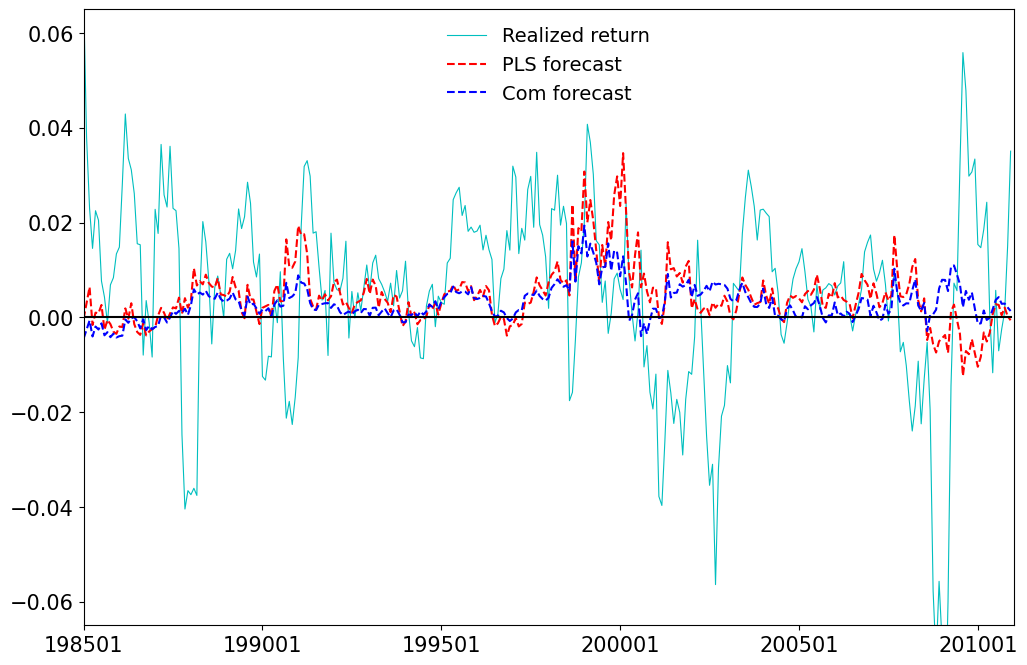

In [147]:
#Figure 2 PLS and Com prediction results comparison
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Create a new figure
fig = plt.figure(figsize=(12, 8))  # Set the figure size
ax = fig.add_subplot(111)  # Add a subplot

# Set the x-axis major ticks to appear every 60 units
ax.xaxis.set_major_locator(MultipleLocator(60))

# Convert the forecast period indices to strings for x-axis labels
xtick = [str(x) for x in forperiod]

# Set the y-axis range
plt.ylim(-0.065, 0.065)  # Limit the y-axis to range between -0.065 and 0.065

# Set the x-axis range
plt.xlim(0, q)  # Limit the x-axis to range between 0 and `q`

# Customize the font size of x and y ticks
plt.xticks(size=15)
plt.yticks(size=15)

# Plot the rolling mean of realized returns (6-month window)
plt.plot(
    xtick,
    df_ret.loc[forperiod, 'Rm'].rolling(window=6, min_periods=1).mean(),
    'c-',  # Cyan solid line
    linewidth=0.8,  # Line width
    label='Realized return'  # Label for the legend
)

# Plot the PLS forecast
plt.plot(
    xtick,
    df_Rmf['PLS'],
    'r--',  # Red dashed line
    label='PLS forecast'  # Label for the legend
)

# Plot the Com forecast
plt.plot(
    xtick,
    df_Rmf['Com'],
    'b--',  # Blue dashed line
    label='Com forecast'  # Label for the legend
)

# Plot a horizontal line at y = 0
plt.plot(
    xtick,
    np.zeros(q),
    'k-'  # Black solid line
)

# Add a legend
plt.legend(
    loc=9,  # Upper center position
    fontsize=14,  # Font size
    frameon=False  # No border around the legend
)

# Optional: Save the figure as a high-resolution image (uncomment to save)
# plt.savefig('Figure2', dpi=500, pad_inches=0.0)

# Display the plot
plt.show()

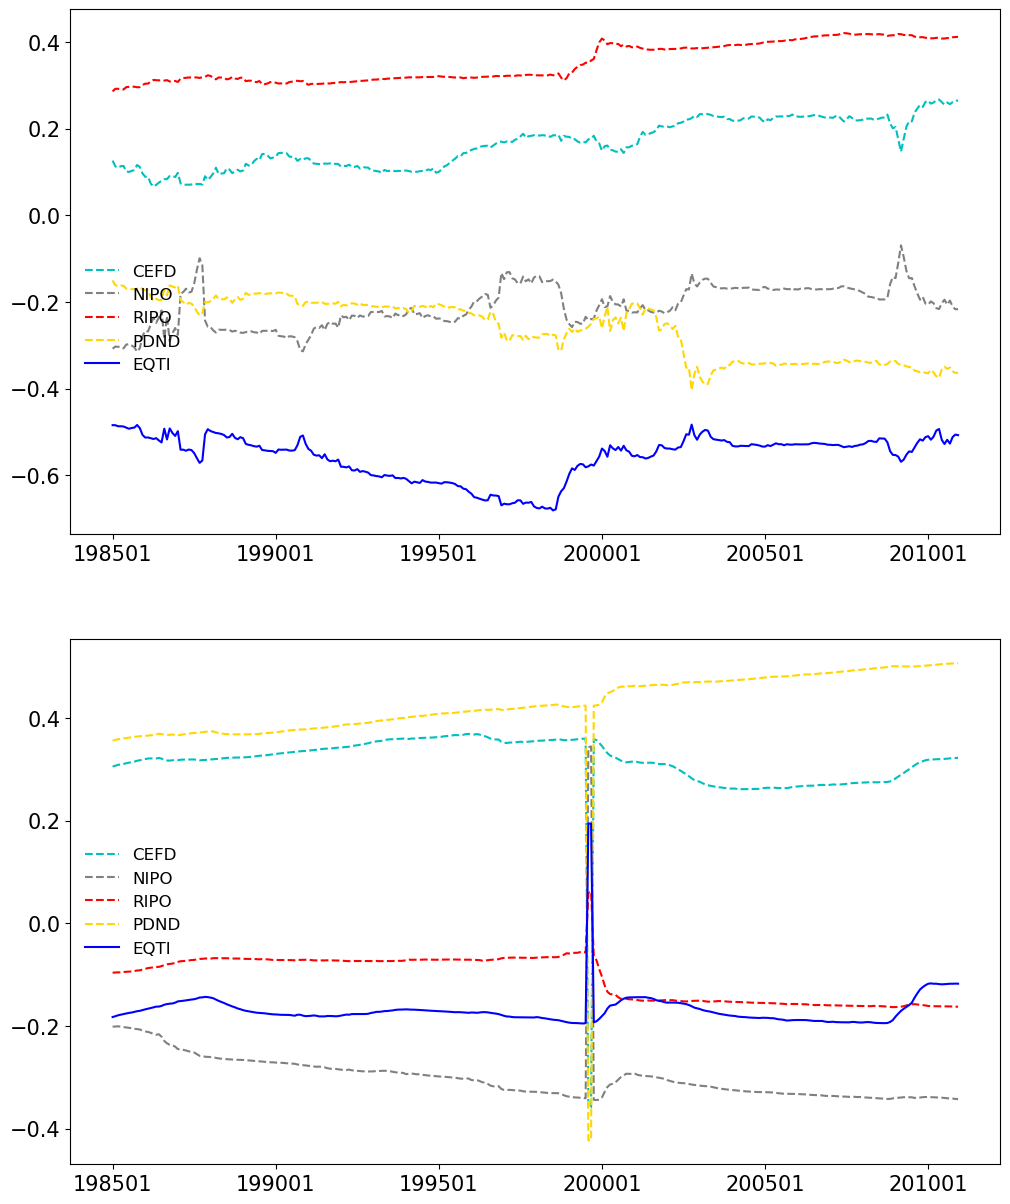

In [151]:
# Initialize matrices to store weights for PLS and BW models
w_pls = np.zeros(5)  # Start with a zero vector (5 predictors)
w_bw = np.zeros(5)

# Loop through each forecast period to calculate weights dynamically
for i in range(q):  # `q` is the number of forecast periods
    period = df_forc.index[:p + i]  # Define the period for OLS regression (expanding window)
    y1 = plss[i]  # Dependent variable for PLS
    y2 = bws[i]  # Dependent variable for BW
    x = df_forc.loc[period, ['CEFD', 'NIPO', 'RIPO1', 'PDND1', 'EQTI']]  # Predictor variables

    # Perform OLS regression and get the weights (coefficients)
    params1 = sma.OLS(y1, x).fit().params.values  # Weights for PLS model
    params2 = sma.OLS(y2, x).fit().params.values  # Weights for BW model

    # Append the calculated weights to the matrices
    w_pls = np.vstack((w_pls, params1))  # Update PLS weights
    w_bw = np.vstack((w_bw, params2))  # Update BW weights

# Plot the dynamic weights for PLS and BW models
fig = plt.figure(figsize=(12, 15))  # Create a figure with size 12x15

# Plot weights for the PLS model
ax1 = fig.add_subplot(211)  # Add the first subplot
plt.xticks(size=15)  # Set x-axis tick label size
plt.yticks(size=15)  # Set y-axis tick label size
ax1.xaxis.set_major_locator(MultipleLocator(60))  # Set x-axis major ticks every 60 units

# Plot the weights for each predictor in the PLS model
ax1.plot(xtick, w_pls[1:, 0], 'c--', label='CEFD')  # CEFD (cyan dashed line)
ax1.plot(xtick, w_pls[1:, 1], '--', color='grey', label='NIPO')  # NIPO (grey dashed line)
ax1.plot(xtick, w_pls[1:, 2], 'r--', label='RIPO')  # RIPO (red dashed line)
ax1.plot(xtick, w_pls[1:, 3], '--', color='gold', label='PDND')  # PDND (gold dashed line)
ax1.plot(xtick, w_pls[1:, 4], 'b-', label='EQTI')  # EQTI (blue solid line)

# Add a legend for the PLS model
ax1.legend(loc=3, bbox_to_anchor=(0, 0.28), fontsize=12, frameon=False)  # Legend placed at the bottom-left corner

# Plot weights for the BW model
ax2 = fig.add_subplot(212)  # Add the second subplot
plt.xticks(size=15)  # Set x-axis tick label size
plt.yticks(size=15)  # Set y-axis tick label size
ax2.xaxis.set_major_locator(MultipleLocator(60))  # Set x-axis major ticks every 60 units

# Plot the weights for each predictor in the BW model
ax2.plot(xtick, w_bw[1:, 0], 'c--', label='CEFD')  # CEFD (cyan dashed line)
ax2.plot(xtick, w_bw[1:, 1], '--', color='grey', label='NIPO')  # NIPO (grey dashed line)
ax2.plot(xtick, w_bw[1:, 2], 'r--', label='RIPO')  # RIPO (red dashed line)
ax2.plot(xtick, w_bw[1:, 3], '--', color='gold', label='PDND')  # PDND (gold dashed line)
ax2.plot(xtick, w_bw[1:, 4], 'b-', label='EQTI')  # EQTI (blue solid line)

# Add a legend for the BW model
ax2.legend(loc=6, fontsize=12, frameon=False)  # Legend placed on the left side

# Optional: Save the figure as a high-resolution image (uncomment to save)
# plt.savefig('Figure3', dpi=500, pad_inches=0.0)

# Display the plot
plt.show()

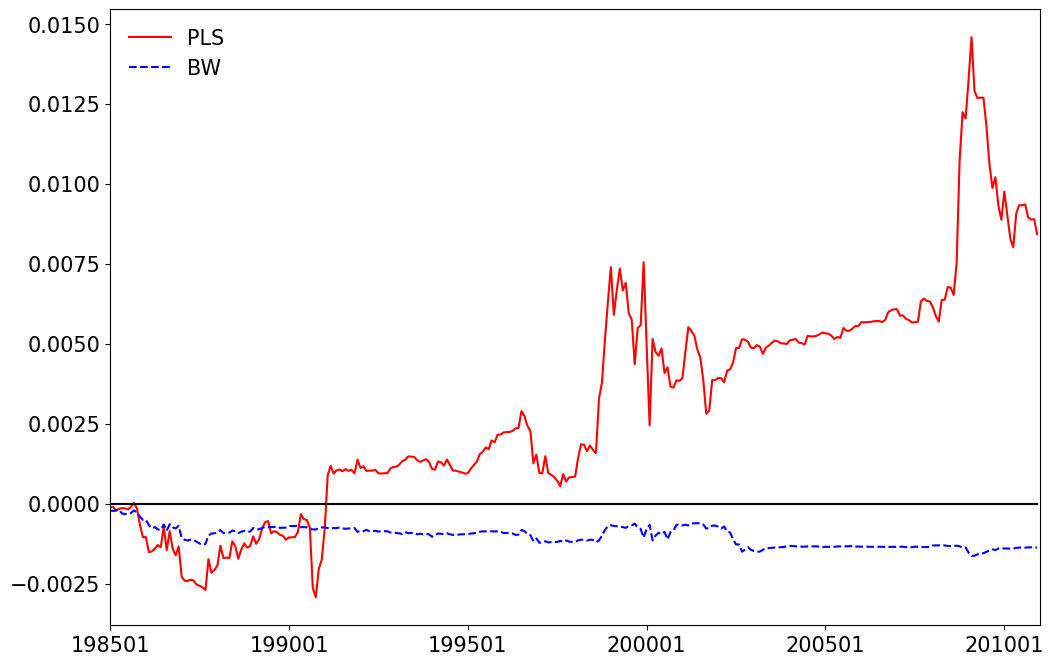

In [153]:
#Figure 4 Cumulative square error change
# Initialize lists to store cumulative squared forecast errors (CSE) for PLS and BW
pls_cses = []  # CSE for PLS model
bw_cses = []   # CSE for BW model

# Loop through each day in the forecast period to calculate cumulative errors
for i in range(q):  # `q` is the number of forecast periods
    # Calculate cumulative squared error for PLS
    pls_cse = np.sum(seh[0:i+1] - mat_sef[3, 0:i+1])  # Difference between benchmark and PLS forecast error
    pls_cses.append(pls_cse)  # Append the cumulative error to the list

    # Calculate cumulative squared error for BW
    bw_cse = np.sum(seh[0:i+1] - mat_sef[0, 0:i+1])  # Difference between benchmark and BW forecast error
    bw_cses.append(bw_cse)  # Append the cumulative error to the list

# Create a new figure for the plot
fig = plt.figure(figsize=(12, 8))  # Set figure size
ax = fig.add_subplot(111)  # Add a subplot

# Set major ticks for the x-axis
ax.xaxis.set_major_locator(MultipleLocator(60))  # Ticks appear every 60 units

# Plot the cumulative squared errors
ax.plot(xtick, pls_cses, 'r-', label='PLS')  # PLS CSE in red solid line
ax.plot(xtick, bw_cses, 'b--', label='BW')  # BW CSE in blue dashed line

# Plot a horizontal line at y=0
ax.plot(xtick, np.zeros(q), 'k-')  # Black solid line at y=0

# Customize the x and y ticks
plt.xticks(size=15)  # Set x-axis tick label size
plt.yticks(size=15)  # Set y-axis tick label size

# Set the x-axis range
plt.xlim(0, q)  # Limit x-axis to the range [0, q]

# Add a legend to the plot
plt.legend(loc=2, fontsize=15, frameon=False)  # Legend in top-left corner, no frame

# Optional: Save the figure as a high-resolution image (uncomment to save)
# plt.savefig('Figure4', dpi=500, pad_inches=0.0)

# Display the plot
plt.show()

In [169]:
#Table 6 Long-term forecast
# Load the data
data_sentiment = pd.read_excel('data_sentiment.xlsx')
data_economic = pd.read_excel('data3.xlsx')

# Extract required data
S_PLS = data_sentiment[['yyyymm', 'PLS']]
S_BW = data_sentiment[['yyyymm', 'BW']]
R_m = data_economic[['yyyymm', 'Rm']]

# Create lagged variables for PLS and BW
lags = [1, 3, 6, 9, 12, 24]  # Lag lengths
SPLS_lags = {f"lag_{lag}": S_PLS.shift(lag).dropna() for lag in lags}
SBW_lags = {f"lag_{lag}": S_BW.shift(lag).dropna() for lag in lags}

# Create shifted dependent variables (future returns)
R_m_lags = {f"lag_{lag}": R_m.shift(-lag + 1).dropna() for lag in lags}

# Helper function to run OLS regression
def run_ols(y, x, label):
    """
    Runs an OLS regression and returns results.
    - y: dependent variable (future returns)
    - x: independent variable (sentiment lag)
    - label: model label (PLS or BW)
    """
    results = []
    # Align indices of y and x
    aligned_data = pd.concat([y, x], axis=1, join='inner').dropna()
    y_aligned = aligned_data.iloc[:, 0]  # Dependent variable
    x_aligned = aligned_data.iloc[:, 1]  # Independent variable

    X = sma.add_constant(x_aligned)  # Add constant for regression
    model = sma.OLS(y_aligned, X).fit()

    # Format coefficient and p-value with significance markers
    coeff = model.params[x.name] * 100  # Access parameter by name
    p = model.pvalues[x.name] / 2       # Access p-value by name
    t = str(round(coeff, 2))
    if p >= 0.05 and p < 0.1:
        t += '*'
    elif p >= 0.01 and p < 0.05:
        t += '**'
    elif p < 0.01:
        t += '***'

    # Append results: coefficient, t-value, and r-squared
    results.append(t)
    results.append(round(model.tvalues[x.name], 2))  # Access t-value by name
    results.append(round(model.rsquared * 100, 2))
    return results

# Run regressions for PLS
results_pls = []
for lag in lags:
    y = R_m_lags[f"lag_{lag}"]['Rm']
    x = SPLS_lags[f"lag_{lag}"]['PLS']
    results_pls.extend(run_ols(y, x, 'PLS'))

# Run regressions for BW
results_bw = []
for lag in lags:
    y = R_m_lags[f"lag_{lag}"]['Rm']
    x = SBW_lags[f"lag_{lag}"]['BW']
    results_bw.extend(run_ols(y, x, 'BW'))

# Combine results into a DataFrame
columns = ['1M Coeff', '1M t-value', '1M R2',
           '3M Coeff', '3M t-value', '3M R2',
           '6M Coeff', '6M t-value', '6M R2',
           '9M Coeff', '9M t-value', '9M R2',
           '12M Coeff', '12M t-value', '12M R2',
           '24M Coeff', '24M t-value', '24M R2']

# Create a list to store the vertical table data
vertical_results = []

# Convert the PLS results into a vertical table format
for i, lag in enumerate(['1M', '3M', '6M', '9M', '12M', '24M']):  # Loop through each forecast horizon
    # Append a row for each forecast horizon with the model name, lag, coefficient, t-value, and R2
    vertical_results.append(['PLS', lag, results_pls[i * 3], results_pls[i * 3 + 1], results_pls[i * 3 + 2]])

# Convert the BW results into a vertical table format
for i, lag in enumerate(['1M', '3M', '6M', '9M', '12M', '24M']):  # Loop through each forecast horizon
    # Append a row for each forecast horizon with the model name, lag, coefficient, t-value, and R2
    vertical_results.append(['BW', lag, results_bw[i * 3], results_bw[i * 3 + 1], results_bw[i * 3 + 2]])

# Convert the list into a pandas DataFrame
vertical_df = pd.DataFrame(vertical_results, columns=['Model', 'Period', 'Coeff', 't-value', 'R2'])

# Print the vertical table
print(vertical_df)

   Model Period  Coeff    t-value  R2 
0    PLS    1M   -0.32**  -1.68   0.52
1    PLS    3M     -0.05  -0.25   0.01
2    PLS    6M      0.23   1.17   0.26
3    PLS    9M    0.35**   1.76   0.58
4    PLS   12M    0.5***   2.54   1.23
5    PLS   24M   -0.5***  -2.49   1.24
6     BW    1M     -0.14  -0.81   0.12
7     BW    3M     -0.17  -0.98   0.18
8     BW    6M     -0.03  -0.18   0.01
9     BW    9M      0.06   0.33   0.02
10    BW   12M    0.31**   1.70   0.55
11    BW   24M      -0.1  -0.55   0.06


In [173]:
data_sentiment = pd.read_excel('data_sentiment.xlsx')
data_economic = pd.read_excel('data3.xlsx')
data_forecast = pd.read_excel('data_forecast.xlsx')

In [175]:
def CER_cal(Rm_forecast, Rm, Rf, transaction_cost, gamma):
    # Function to calculate the Certainty Equivalent Return (CER) difference, Sharpe ratio,
    # and other performance metrics for portfolio optimization.
    #
    # Parameters:
    # Rm_forecast: Forecasted market returns (a DataFrame with 'yyyymm' and return columns)
    # Rm: Actual market returns (a DataFrame with 'yyyymm' and return columns)
    # Rf: Risk-free returns (a DataFrame with 'yyyymm' and return columns)
    # transaction_cost: Transaction cost (as a percentage, e.g., 0.1 for 0.1%)
    # gamma: Risk aversion coefficient (a parameter for portfolio optimization)

    # Copy input data to avoid modifying the original data
    Rm_forecast = Rm_forecast
    Rm_real = Rm
    Rf = Rf
    cost = transaction_cost
    gamma = gamma    

    # Calculate future variance (var_t+1) using a 5-year rolling window (60 months) of actual returns
    row_begin_1 = Rm_real[Rm_real['yyyymm'] == 198001].index[0]  # Find the start index for January 1980
    var_forecast = Rm_real.iloc[row_begin_1:, :].copy()  # Subset data starting from January 1980
    var_forecast['Rm'] = var_forecast['Rm'].rolling(60).var().shift(1)  # Calculate rolling variance, shifted by 1 month
    var_forecast = var_forecast.dropna().rename(columns={'Rm': 'var'})  # Drop NaN rows and rename column to 'var'

    # Case 1: Portfolio optimization when transaction cost is zero
    if cost == 0:
        # Calculate portfolio weights (w_t), portfolio returns (R_p_t+1), and excess returns
        w_t = []  # Portfolio weights
        R_p = []  # Portfolio returns
        R_p_excess = []  # Excess returns (used for calculating Sharpe ratio)

        # Find the start index for January 1985
        row_begin_2 = Rm_real[Rm_real['yyyymm'] == 198501].index[0]
        Rm_real_85to10 = Rm_real.iloc[row_begin_2:, :].copy()  # Subset data starting from January 1985

        # Loop through the forecasted data
        for i in range(0, 312):  # Assume 312 months of data (1985 to 2010)
            # Calculate portfolio weight based on forecasted return and future variance
            w_t.append(1 / gamma * Rm_forecast.iloc[i, 1] / var_forecast.iloc[i, 1])  
            # Constrain weights: set to 0 if negative, max at 1.5
            if w_t[i] < 0:
                w_t[i] = 0
            elif w_t[i] > 1.5:
                w_t[i] = 1.5
            
            # Calculate portfolio return for the current month
            R_p.append(w_t[i] * Rm_real_85to10.iloc[i, 1] + Rf.iloc[i, 1])
            # Calculate excess return (for Sharpe ratio)
            R_p_excess.append(w_t[i] * Rm_real_85to10.iloc[i, 1])

        # Calculate a naive forecast of returns based on historical averages
        Rm_forecast_naive = Rm_forecast.iloc[:, :2]  # Subset the first two columns
        for i in range(0, 312):
            # Historical average return up to the current month
            Rm_forecast_naive.iloc[i, 1] = np.mean(Rm_real.iloc[0:233 + i, 1])

        # Calculate portfolio weights and returns using naive forecasts
        w_naive_t = []  # Portfolio weights based on naive forecast
        R_p_naive = []  # Portfolio returns based on naive forecast

        for i in range(0, 312):
            # Calculate portfolio weight based on naive forecast
            w_naive_t.append(1 / gamma * Rm_forecast_naive.iloc[i, 1] / var_forecast.iloc[i, 1])  
            # Constrain weights: set to 0 if negative, max at 1.5
            if w_naive_t[i] < 0:
                w_naive_t[i] = 0
            elif w_naive_t[i] > 1.5:
                w_naive_t[i] = 1.5

            # Calculate portfolio return for the current month
            R_p_naive.append(w_naive_t[i] * Rm_real.iloc[row_begin_2 + i, 1] + Rf.iloc[i, 1])

        # Calculate the Certainty Equivalent Return (CER) for both strategies
        CER_p = np.average(R_p) - 0.5 * gamma * np.var(R_p)  # CER for optimized portfolio
        CER_naive = np.average(R_p_naive) - 0.5 * gamma * np.var(R_p_naive)  # CER for naive portfolio
        CER_delta = (CER_p - CER_naive) * 12  # Annualized CER difference

        # Calculate the Sharpe ratio (mean excess return divided by standard deviation)
        sharp_ratio = np.mean(R_p_excess) / np.std(R_p_excess)

    # Case 2: Portfolio optimization when transaction cost is non-zero
    else:
        w_t = []  # Portfolio weights
        R_p = []  # Portfolio returns
        R_p_excess = []  # Excess returns (used for calculating Sharpe ratio)

        # Find the start index for January 1985
        row_begin_2 = Rm_real[Rm_real['yyyymm'] == 198501].index[0]
        Rm_real_85to10 = Rm_real.iloc[row_begin_2:, :].copy()  # Subset data starting from January 1985

        # Loop through the forecasted data
        for i in range(0, 312):  # Assume 312 months of data (1985 to 2010)
            # Calculate portfolio weight based on forecasted return and future variance
            w_t.append(1 / gamma * Rm_forecast.iloc[i, 1] / var_forecast.iloc[i, 1])  
            # Constrain weights: set to 0 if negative, max at 1.5
            if w_t[i] < 0:
                w_t[i] = 0
            elif w_t[i] > 1.5:
                w_t[i] = 1.5

            # Calculate portfolio return considering transaction costs
            if i < 1:  # No transaction cost for the first month
                R_p.append(w_t[i] * Rm_real_85to10.iloc[i, 1] + Rf.iloc[i, 1])
                R_p_excess.append(w_t[i] * Rm_real_85to10.iloc[i, 1])  # Excess return
                
            if i > 1:
                if w_t[i] == w_t[i - 1]:  # No transaction cost if weight remains the same
                    R_p.append(w_t[i] * Rm_real_85to10.iloc[i, 1] + Rf.iloc[i, 1])
                    R_p_excess.append(w_t[i] * Rm_real_85to10.iloc[i, 1])
                else:  # Apply transaction cost when weights change
                    R_p.append((w_t[i] * Rm_real_85to10.iloc[i, 1] + Rf.iloc[i, 1]) * (1 - cost / 10000))
                    R_p_excess.append((w_t[i] * Rm_real_85to10.iloc[i, 1]) * (1 - cost / 10000))

        # Repeat naive forecast calculations as above
        Rm_forecast_naive = Rm_forecast.iloc[:, :2]  # Subset the first two columns
        for i in range(0, 312):
            Rm_forecast_naive.iloc[i, 1] = np.mean(Rm_real.iloc[0:233 + i, 1])

        w_naive_t = []  # Portfolio weights based on naive forecast
        R_p_naive = []  # Portfolio returns based on naive forecast

        for i in range(0, 312):
            w_naive_t.append(1 / gamma * Rm_forecast_naive.iloc[i, 1] / var_forecast.iloc[i, 1])  
            if w_naive_t[i] < 0:
                w_naive_t[i] = 0
            elif w_naive_t[i] > 1.5:
                w_naive_t[i] = 1.5

            if i < 1:
                R_p_naive.append(w_naive_t[i] * Rm_real_85to10.iloc[i, 1] + Rf.iloc[i, 1])
            if i > 1:
                if w_naive_t[i] == w_naive_t[i - 1]:
                    R_p_naive.append(w_naive_t[i] * Rm_real_85to10.iloc[i, 1] + Rf.iloc[i, 1])
                else:
                    R_p_naive.append((w_naive_t[i] * Rm_real_85to10.iloc[i, 1] + Rf.iloc[i, 1]) * (1 - cost / 10000))

        # Calculate the Certainty Equivalent Return (CER) for both strategies
        CER_p = np.average(R_p) - 0.5 * gamma * np.var(R_p)  # CER for optimized portfolio
        CER_naive = np.average(R_p_naive) - 0.5 * gamma * np.var(R_p_naive)  # CER for naive portfolio
        CER_delta = (CER_p - CER_naive) * 12  # Annualized CER difference

        # Calculate the Sharpe ratio
        sharp_ratio = np.mean(R_p_excess) / np.std(R_p_excess)

    # Return the computed metrics
    return [CER_delta, sharp_ratio, cost, gamma]

In [177]:
#Table 7 Asset Allocation Results
result = []
for cost in [0, 50]:
    for gamma in [1,3,5]:
        for name in ['BW', 'EW', 'Com', 'PLS']:
            result.extend(CER_cal(Rm_forecast = data_forecast[['yyyymm', name]], Rm = data_economic[['yyyymm', 'Rm']],Rf = data_forecast[['yyyymm','Rf']], transaction_cost = cost, gamma = gamma))
result = pd.DataFrame(np.reshape(result,(24,4)),columns = ['CER gain(%)','Sharpe ratio','Transaction cost','Gamma'],index = ['S_BW','S_EW','S_Com','S_PLS'] * 6)
result
#result.to_excel( 'Table7.xlsx')

,CER gain(%),Sharpe ratio,Transaction cost,Gamma
S_BW,0.01,0.09,0.00,1.00
S_EW,0.02,0.10,0.00,1.00
S_Com,0.02,0.11,0.00,1.00
S_PLS,0.03,0.12,0.00,1.00
S_BW,-0.00,0.07,0.00,3.00
S_EW,-0.00,0.06,0.00,3.00
S_Com,0.02,0.10,0.00,3.00
S_PLS,0.03,0.13,0.00,3.00
S_BW,-0.01,0.05,0.00,5.00
S_EW,-0.01,0.04,0.00,5.00


In [207]:
data_sentiment = pd.read_excel('data5.xlsx')
data_industry = pd.read_csv('Industry_Portfolios.csv',skiprows=11)
data_size = pd.read_csv('Size_Portfolios.csv',skiprows=12)
data_bm = pd.read_csv( 'BM_Portfolios.csv',skiprows=23)
data_momentum = pd.read_csv('Momentum_Portfolios.csv',skiprows=10)
row_begin = data_industry[data_industry['Date'] == '196507'].index[0]
row_end = data_industry[data_industry['Date'] == '201012'].index[0]
data_industry = data_industry.iloc[row_begin:row_end+1,:]
row_begin = data_size[data_size['Date'] == '196507'].index[0]
row_end = data_size[data_size['Date'] == '201012'].index[0]
data_size = data_size.iloc[row_begin:row_end+1,:]
row_begin = data_bm[data_bm['Date'] == '196507'].index[0]
row_end = data_bm[data_bm['Date'] == '201012'].index[0]
data_bm = data_bm.iloc[row_begin:row_end+1,:]
row_begin = data_momentum[data_momentum['Date'] == '196507'].index[0]
row_end = data_momentum[data_momentum['Date'] == '201012'].index[0]
data_momentum = data_momentum.iloc[row_begin:row_end+1,:]
data_sentiment = data_sentiment[['yearmo','PLS','BW']]
data_industry['Date'] = data_industry['Date'].apply(pd.to_numeric)
data_industry_PLS = pd.merge(data_industry,data_sentiment, left_on = 'Date', right_on = 'yearmo')
data_industry_PLS[['yearmo','PLS','BW']] = data_industry_PLS[['yearmo','PLS','BW']].shift(1)
data_industry_PLS = data_industry_PLS.dropna()
data_size['Date'] = data_size['Date'].apply(pd.to_numeric)
data_size_PLS = pd.merge(data_size,data_sentiment, left_on = 'Date', right_on = 'yearmo')
data_size_PLS[['yearmo','PLS','BW']] = data_size_PLS[['yearmo','PLS','BW']].shift(1)
data_size_PLS = data_size_PLS.dropna()
data_bm['Date'] = data_bm['Date'].apply(pd.to_numeric)
data_bm_PLS = pd.merge(data_bm,data_sentiment, left_on = 'Date', right_on = 'yearmo')
data_bm_PLS[['yearmo','PLS','BW']] = data_bm_PLS[['yearmo','PLS','BW']].shift(1)
data_bm_PLS = data_bm_PLS.dropna()
data_momentum['Date'] = data_momentum['Date'].apply(pd.to_numeric)
data_momentum_PLS = pd.merge(data_momentum,data_sentiment, left_on = 'Date', right_on = 'yearmo')
data_momentum_PLS[['yearmo','PLS','BW']] = data_momentum_PLS[['yearmo','PLS','BW']].shift(1)
data_momentum_PLS = data_momentum_PLS.dropna()

In [209]:
data_size_PLS

,Date,<= 0,Lo 30,Med 40,Hi 30,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,...,4-Dec,5-Dec,6-Dec,7-Dec,8-Dec,9-Dec,Hi 10,yearmo,PLS,BW
1,196508,-99.99,4.21,5.14,2.78,4.22,4.8,6.1,4.19,2.65,...,5.25,7.33,5.26,4.02,4.29,3.47,2.48,196507.00,-1.19,-1.91
2,196509,-99.99,2.67,3.42,3.18,2.64,3.97,3.39,3.06,3.19,...,4.88,3.48,3.32,2.96,3.12,2.85,3.26,196508.00,-0.24,-1.92
3,196510,-99.99,6.85,4.72,2.56,7.45,5.85,5.21,3.9,2.42,...,6,5.79,4.81,3.72,4.01,3.62,2.17,196509.00,-0.15,-1.82
4,196511,-99.99,4.86,4.37,-0.39,5.92,4.87,4.44,3.35,-0.72,...,6.48,5.31,3.81,3.55,3.22,1.56,-1.2,196510.00,-0.29,-1.66
5,196512,-99.99,4.54,3.23,0.94,4.58,5.01,2.79,2.09,0.88,...,5.4,2.18,3.23,2.94,1.58,1.8,0.68,196511.00,0.24,-1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,201008,-99.99,-8.49,-5.96,-4.39,-8.93,-7.33,-6.23,-4.75,-4.37,...,-6.96,-7.35,-5.46,-5.07,-4.58,-4.39,-4.37,201007.00,0.11,-0.29
542,201009,-99.99,12.18,12.04,9.07,11.7,13.36,12.66,10.75,8.88,...,13.72,12.83,12.54,10.33,10.98,10.39,8.55,201008.00,0.43,-0.20
543,201010,-99.99,4.8,3.2,3.92,5.28,3.32,4.05,3.49,3.9,...,2.72,4.08,4.03,2.22,4.15,3.67,3.95,201009.00,0.27,-0.20
544,201011,-99.99,3.71,3.39,0.13,3.83,3.67,4.06,2.93,-0.21,...,3.79,4.33,3.87,2.21,3.3,1.37,-0.55,201010.00,0.59,-0.32


In [211]:
def signif2(result,i):
    beta=str(round(result.params[i]*1000,2))
    p=result.pvalues[i]/50
    if p>=0.05 and p<0.1:
        beta=beta+'*'
    elif p>=0.01 and p<0.05:
        beta=beta+'**'
    elif p<0.01:
        beta=beta+'***'
    return beta
def signif3(result,i):
    beta=str(round(result.params[i]*10000,2))
    p=result.pvalues[i]/50
    if p>=0.05 and p<0.1:
        beta=beta+'*'
    elif p>=0.01 and p<0.05:
        beta=beta+'**'
    elif p<0.01:
        beta=beta+'***'
    return beta
def signif4(result,i):
    beta=str(round(result.params[i]*100000,2))
    p=result.pvalues[i]/50
    if p>=0.05 and p<0.1:
        beta=beta+'*'
    elif p>=0.01 and p<0.05:
        beta=beta+'**'
    elif p<0.01:
        beta=beta+'***'
    return beta

In [213]:
# Initialize an empty list to store the results for industry models
results_industry = []  # This list will store coefficients, t-values, and R-squared values for each regression

# Loop through the columns (industries) in `data_industry_PLS` for the PLS variable
for i in range(1, 11):  # Assuming columns 1 to 10 represent industries
    # Extract the dependent variable `y` (as numeric data)
    y = list(data_industry_PLS.iloc[:, i].apply(pd.to_numeric))

    # Extract the independent variable `PLS` and add a constant for the regression intercept
    X = sma.add_constant(list(data_industry_PLS['PLS']))

    # Fit an OLS (Ordinary Least Squares) regression model
    model = sma.OLS(y, X).fit()

    # Extract the coefficient for the independent variable (`PLS`)
    t = model.params[1]  # Coefficient of the independent variable

    # Extract the one-tailed p-value for the independent variable's coefficient
    p = model.pvalues[1] / 2  # Divide by 2 for a one-tailed test

    # Round the coefficient to 2 decimal places and convert it to a string
    t = str(round(t, 2))

    # Add significance stars based on the p-value
    if p >= 0.05 and p < 0.1:  # Marginal significance
        t = t + '*'  # Add one star
    elif p >= 0.01 and p < 0.05:  # Significant
        t = t + '**'  # Add two stars
    elif p < 0.01:  # Highly significant
        t = t + '***'  # Add three stars

    # Append the results for this model to the `results_industry` list
    results_industry.append(t)  # Coefficient with significance stars
    results_industry.append(round(model.tvalues[1], 2))  # t-value of the coefficient
    results_industry.append(round(model.rsquared * 100, 2))  # R-squared as a percentage

# Repeat the analysis for the `BW` variable instead of `PLS`
for i in range(1, 11):  # Loop through the same industries
    # Extract the dependent variable `y` (as numeric data)
    y = list(data_industry_PLS.iloc[:, i].apply(pd.to_numeric))

    # Extract the independent variable `BW` and add a constant for the regression intercept
    X = sma.add_constant(list(data_industry_PLS['BW']))

    # Fit an OLS regression model
    model = sma.OLS(y, X).fit()

    # Extract the coefficient for the independent variable (`BW`)
    t = model.params[1]  # Coefficient of the independent variable

    # Extract the one-tailed p-value for the independent variable's coefficient
    p = model.pvalues[1] / 2  # Divide by 2 for a one-tailed test

    # Round the coefficient to 2 decimal places and convert it to a string
    t = str(round(t, 2))

    # Add significance stars based on the p-value
    if p >= 0.05 and p < 0.1:  # Marginal significance
        t = t + '*'  # Add one star
    elif p >= 0.01 and p < 0.05:  # Significant
        t = t + '**'  # Add two stars
    elif p < 0.01:  # Highly significant
        t = t + '***'  # Add three stars

    # Append the results for this model to the `results_industry` list
    results_industry.append(t)  # Coefficient with significance stars
    results_industry.append(round(model.tvalues[1], 2))  # t-value of the coefficient
    results_industry.append(round(model.rsquared * 100, 2))  # R-squared as a percentage

In [215]:
results_size = []#Coefficient, p-value, t-value, r-squared

for i in range(10,20):
    y = list(data_size_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_size_PLS['PLS']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_size.append(t)
    results_size.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_size.append(round(model.rsquared*100,2))

for i in range(10,20):
    y = list(data_size_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_size_PLS['BW']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_size.append(t)
    results_size.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_size.append(round(model.rsquared*100,2))

In [217]:
results_bm = []#Coefficient, p-value, t-value, r-squared

for i in range(10,20):
    y = list(data_bm_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_bm_PLS['PLS']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_bm.append(t)
    results_bm.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_bm.append(round(model.rsquared*100,2))

for i in range(10,20):
    y = list(data_bm_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_bm_PLS['BW']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_bm.append(t)
    results_bm.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_bm.append(round(model.rsquared*100,2))

In [219]:
results_momentum = []#Coefficient, p-value, t-value, r-squared

for i in range(1,11):
    y = list(data_momentum_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_momentum_PLS['PLS']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_momentum.append(t)
    results_momentum.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_momentum.append(round(model.rsquared*100,2))

for i in range(1,11):
    y = list(data_momentum_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_momentum_PLS['BW']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_momentum.append(t)
    results_momentum.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_momentum.append(round(model.rsquared*100,2))

In [203]:
# Table 8 Forecasting characteristics portfolios with investor sentiment
df_industry = pd.DataFrame(np.reshape(results_industry,(20,3)),columns=['beta', 't-value', 'R-squared'])
df_size = pd.DataFrame(np.reshape(results_size,(20,3)),columns=['beta', 't-value', 'R-squared'])
df_bm = pd.DataFrame(np.reshape(results_bm,(20,3)),columns=['beta', 't-value', 'R-squared'])
df_momentum = pd.DataFrame(np.reshape(results_momentum,(20,3)),columns=['beta', 't-value', 'R-squared'])

df = pd.concat([df_industry, df_size, df_bm, df_momentum],axis = 0)

df.index = ['NoDurable','Durable','Manufacture','Energy','Technology','Telecom','Shop','Health','Utility','Other','NoDurable','Durable','Manufacture','Energy','Technology','Telecom','Shop','Health','Utility','Other','Small','2','3','4','5','6','7','8','9','Large','Small','2','3','4','5','6','7','8','9','Large','Growth','2','3','4','5','6','7','8','9','Value','Growth','2','3','4','5','6','7','8','9','Value', 'Loser','2','3','4','5','6','7','8','9','Winner','Loser','2','3','4','5','6','7','8','9','Winner']

df_PLS_industry = df.iloc[0:10,:];df_PLS_industry = df_PLS_industry.rename(columns={'beta':'beta_PLS'}) 
df_BW_industry  = df.iloc[10:20,:];df_BW_industry = df_BW_industry.rename(columns={'beta':'beta_BW'}) 
df_PLS_size = df.iloc[20:30,:];df_PLS_size = df_PLS_size.rename(columns={'beta':'beta_PLS'}) 
df_BW_size  = df.iloc[30:40,:];df_BW_size = df_BW_size.rename(columns={'beta':'beta_BW'}) 
df_PLS_bm  = df.iloc[40:50,:];df_PLS_bm = df_PLS_bm.rename(columns={'beta':'beta_PLS'}) 
df_BW_bm  = df.iloc[50:60,:];df_BW_bm = df_BW_bm.rename(columns={'beta':'beta_BW'}) 
df_PLS_momentum  = df.iloc[60:70,:];df_PLS_momentum = df_PLS_momentum.rename(columns={'beta':'beta_PLS'}) 
df_BW_momentum  = df.iloc[70:80,:];df_BW_momentum = df_BW_momentum.rename(columns={'beta':'beta_BW'})

df_industry = pd.concat([df_PLS_industry, df_BW_industry], axis = 1)
df_size = pd.concat([df_PLS_size, df_BW_size], axis = 1)
df_bm = pd.concat([df_PLS_bm, df_BW_bm], axis = 1)
df_momentum = pd.concat([df_PLS_momentum, df_BW_momentum], axis = 1)

df =  pd.concat([df_industry, df_size, df_bm, df_momentum], axis = 0)
df
#df.to_excel('Table8.xlsx')

,beta_PLS,t-value,R-squared,beta_BW,t-value,R-squared
NoDurable,-0.52***,-2.75,1.37,0.02,0.13,0.0
Durable,-0.6**,-2.2,0.88,-0.04,-0.14,0.0
Manufacture,-0.71***,-3.28,1.94,-0.16,-0.78,0.11
Energy,-0.66***,-2.84,1.46,-0.28*,-1.29,0.31
Technology,-1.4***,-4.91,4.26,-0.49**,-1.81,0.6
Telecom,-0.43**,-2.09,0.8,-0.17,-0.89,0.15
Shop,-0.87***,-3.8,2.59,0.04,0.18,0.01
Health,-0.46**,-2.13,0.83,0.05,0.26,0.01
Utility,-0.22,-1.24,0.28,-0.04,-0.25,0.01
Other,-0.95***,-4.13,3.05,-0.24,-1.11,0.22


In [223]:
# Load the data
df = pd.read_excel("SP500.xlsx")

# Extract the year from the "Data Date - Index Monthly" column
df["year"] = df["Data Date - Index Monthly"].astype(str).str[:4]

# Calculate yearly average for Dividend, Dividend Growth (DG)
dividend = df.groupby("year", as_index=False)["Dividend"].mean().rename(columns={"Dividend": "Dividend_Year"})
dividend["DG"] = np.log(dividend["Dividend_Year"]).diff()  # Calculate log difference for growth (DG)
df = pd.merge(df, dividend, on="year", how="inner")  # Merge back into the original DataFrame

# Calculate yearly average for Earnings, Earnings Growth (EG)
earnings = df.groupby("year", as_index=False)["Earnings"].mean().rename(columns={"Earnings": "Earnings_Year"})
earnings["EG"] = np.log(earnings["Earnings_Year"]).diff()  # Calculate log difference for growth (EG)
df = pd.merge(df, earnings, on="year", how="inner")  # Merge back into the original DataFrame

# Calculate yearly average for Price
price = df.groupby("year", as_index=False)["Price"].mean().rename(columns={"Price": "Price_Year"})
df = pd.merge(df, price, on="year", how="inner")  # Merge back into the original DataFrame

# Calculate the Dividend-to-Price ratio (DP)
df["DP"] = np.log(df["Price"] / df["Dividend"])

In [225]:
data = pd.read_excel('data4.xlsx')
data['lagDP'] = data['DP'].shift(1)
data['lagPLS'] = data['PLS'].shift(1) 
data['lagBW'] = data['BW'].shift(1) 
data.head()

,Unnamed: 0,Data Date Monthly,year,DG,EG,DP,GDPG,BW,PLS,lagDP,lagPLS,lagBW
0,1,1965-12-31,1965,NaN,NaN,5.84,NaN,-1.69,0.24,NaN,NaN,NaN
1,2,1966-12-31,1966,-0.00,0.08,5.73,-0.01,-1.18,0.08,5.84,0.24,-1.69
2,3,1967-12-31,1967,0.02,-0.00,5.92,0.01,-0.35,-3.35,5.73,0.08,-1.18
3,4,1968-12-31,1968,0.05,0.03,5.92,-0.00,2.15,-0.28,5.92,-3.35,-0.35
4,5,1969-12-31,1969,0.03,0.05,5.80,-0.01,3.10,2.94,5.92,-0.28,2.15


In [239]:
# Update signif function to avoid warnings
def signif(result, i):
    # Access the coefficient and p-value using .iloc for positional indexing
    beta = str(round(result.params.iloc[i], 2))  # Use .iloc for positional access
    p = result.pvalues.iloc[i]  # Use .iloc for positional access

    # Add significance stars based on the p-value
    if p >= 0.05 and p < 0.1:
        beta += '*'
    elif p >= 0.01 and p < 0.05:
        beta += '**'
    elif p < 0.01:
        beta += '***'
    return beta


# Update signif1 function if it exists and uses the same indexing
def signif1(result, i):
    beta = str(round(result.params.iloc[i], 2))  # Use .iloc for positional access
    p = result.pvalues.iloc[i]  # Use .iloc for positional access

    if p >= 0.05 and p < 0.1:
        beta += '*'
    elif p >= 0.01 and p < 0.05:
        beta += '**'
    elif p < 0.01:
        beta += '***'
    return beta

In [241]:
#Table 9A Forecasted cash flows and discount rates based on PLS investor sentiment
# Main loop for regression
econ_pre = ['DP', 'DG', 'EG', 'GDPG']  # Economic predictors
betas = []  # Store coefficients for lagPLS
tbs = []  # Store t-statistics for lagPLS
psis = []  # Store coefficients for lagDP
tps = []  # Store t-statistics for lagDP
R2s = []  # Store R-squared values

# Loop through each economic predictor
for econ in econ_pre:
    # Define independent variables (lagPLS and lagDP) and add a constant
    x = data.loc[:, ['lagPLS', 'lagDP']]
    x = sma.add_constant(x)  # Add constant to the regression model

    # Define the dependent variable
    y = data[econ]

    # Fit the OLS model
    model = sma.OLS(y, x, missing='drop')  # Handle missing values by dropping them
    result = model.fit()  # Fit the regression model

    # Extract coefficients and significance for `lagPLS` (index 1)
    if econ == 'DP':
        beta = signif1(result, 1)  # Use signif1 for DP
    else:
        beta = signif(result, 1)  # Use signif for other predictors

    # Extract t-statistic for `lagPLS` (index 1)
    tb = round(result.tvalues.iloc[1], 2)  # Use .iloc for positional access

    # Extract coefficients and significance for `lagDP` (index 2)
    if econ == 'DP':
        psi = signif1(result, 2)  # Use signif1 for DP
    else:
        psi = signif(result, 2)  # Use signif for other predictors

    # Extract t-statistic for `lagDP` (index 2)
    tp = round(result.tvalues.iloc[2], 2)  # Use .iloc for positional access

    # Extract R-squared value and convert to percentage
    R2 = round(result.rsquared * 100, 2)

    # Append results to their corresponding lists
    betas.append(beta)
    tbs.append(tb)
    psis.append(psi)
    tps.append(tp)
    R2s.append(R2)

# Create a DataFrame to store and display the results
table9A = pd.DataFrame(
    index=econ_pre,  # Use econ_pre as the index
    columns=['beta(%)', 't-stat', 'psi(%)', 't-stat', 'R2(%)']  # Define column names
)

# Populate the DataFrame with regression results
table9A['beta(%)'] = betas  # Coefficients for lagPLS
table9A.iloc[:, 1] = tbs  # t-statistics for lagPLS
table9A['psi(%)'] = psis  # Coefficients for lagDP
table9A.iloc[:, 3] = tps  # t-statistics for lagDP
table9A['R2(%)'] = R2s  # R-squared values

# Print the final table
print(table9A)

     beta(%) t-stat  psi(%)  t-stat  R2(%)
DP     -0.01 -0.40   0.91*** 12.97  81.31 
DG      -0.0 -0.53     -0.02 -0.82   1.82 
EG      0.04  0.94       0.1  0.81   2.84 
GDPG    -0.0 -0.42     -0.01 -1.34   4.12 


In [243]:
#Table 9B Forecasted cash flows and discount rates based on BW investor sentiment
# Define the list of economic predictors
econ_pre = ['DP', 'DG', 'EG', 'GDPG']  # Economic indicators to predict
betas = []  # Coefficients for lagBW
tbs = []  # t-statistics for lagBW
psis = []  # Coefficients for lagDP
tps = []  # t-statistics for lagDP
R2s = []  # R-squared values for each regression

# Perform OLS regressions in a loop
for econ in econ_pre:
    # Define the independent variables (lagBW and lagDP) and add a constant for the intercept
    x = data.loc[:, ['lagBW', 'lagDP']]  # Select independent variables
    x = sma.add_constant(x)  # Add a constant column for the regression intercept

    # Define the dependent variable (current economic predictor)
    y = data[econ]  # Dependent variable (e.g., DP, DG, EG, GDPG)

    # Fit the OLS model
    model = sma.OLS(y, x, missing='drop')  # Handle missing values by dropping them
    result = model.fit()  # Fit the regression model

    # Extract the coefficient for `lagBW` (index 1) and format with significance stars
    if econ == 'DP':
        beta = signif1(result, 1)  # Use `signif1` for `DP` to format coefficients
    else:
        beta = signif(result, 1)  # Use `signif` for other dependent variables

    # Extract the t-statistic for `lagBW` (index 1)
    tb = round(result.tvalues.iloc[1], 2)  # Use `.iloc` for positional access

    # Extract the coefficient for `lagDP` (index 2) and format with significance stars
    if econ == 'DP':
        psi = signif1(result, 2)  # Use `signif1` for `DP`
    else:
        psi = signif(result, 2)  # Use `signif` for other dependent variables

    # Extract the t-statistic for `lagDP` (index 2)
    tp = round(result.tvalues.iloc[2], 2)  # Use `.iloc` for positional access

    # Extract R-squared value (as a percentage)
    R2 = round(result.rsquared * 100, 2)  # Convert R-squared to percentage and round

    # Append results to their respective lists
    betas.append(beta)  # Coefficient for lagBW
    tbs.append(tb)  # t-statistic for lagBW
    psis.append(psi)  # Coefficient for lagDP
    tps.append(tp)  # t-statistic for lagDP
    R2s.append(R2)  # R-squared value

# Create a DataFrame to store and display the results for Table 9B
table9B = pd.DataFrame(
    index=econ_pre,  # Use `econ_pre` as the index (row labels)
    columns=['beta(%)', 't-stat', 'psi(%)', 't-stat', 'R2(%)']  # Define column names
)

# Populate the DataFrame with the regression results
table9B['beta(%)'] = betas  # Coefficients for lagBW
table9B.iloc[:, 1] = tbs  # t-statistics for lagBW
table9B['psi(%)'] = psis  # Coefficients for lagDP
table9B.iloc[:, 3] = tps  # t-statistics for lagDP
table9B['R2(%)'] = R2s  # R-squared values

# (Optional) Save the results to an Excel file
# table9B.to_excel('Table9B.xlsx')

# Print the final table
print(table9B)

     beta(%) t-stat  psi(%)  t-stat  R2(%)
DP      -0.0 -0.15   0.92*** 13.19  81.25 
DG     -0.01 -1.32     -0.01 -0.41   5.08 
EG     -0.06 -1.27       0.1  0.87   4.48 
GDPG    -0.0 -0.04     -0.01 -1.23   3.72 


In [247]:
data = pd.read_excel('data7.xlsx')

In [253]:
#Table 10A_PLS Cross-sectional relationship PL
# Function to add significance stars based on p-values
def add_significance(result, idx):
    """
    Add significance stars (*, **, ***) to regression coefficients based on p-values.

    Args:
        result: The regression result object from statsmodels OLS.
        idx: The positional index of the coefficient in the result.

    Returns:
        Coefficient with significance stars as a formatted string.
    """
    coef = round(result.params.iloc[idx], 2)  # Get the coefficient and round it
    p_value = result.pvalues.iloc[idx]  # Get the p-value
    if p_value < 0.01:
        return f"{coef}***"
    elif p_value < 0.05:
        return f"{coef}**"
    elif p_value < 0.1:
        return f"{coef}*"
    else:
        return str(coef)

# Define the list of dependent variables (economic predictors)
econ_pre = ['Small', 'sec', 'thi', 'for', 'fif', 'six', 'sev', 'eig', 'nin', 'Large']

# Initialize lists to store regression results
betas = []  # Coefficients for lagPLS
tbs = []  # t-statistics for lagPLS
R2s = []  # R-squared values for each regression

# Loop through each dependent variable and perform OLS regression
for econ in econ_pre:
    # Define the independent variable (lagPLS) and add a constant for the intercept
    x = data.loc[:, ['lagPLS']]  # Select `lagPLS` as the independent variable
    x = sma.add_constant(x)  # Add constant column for the regression intercept

    # Define the dependent variable
    y = data[econ]  # Current dependent variable (e.g., Small, sec, etc.)

    # Fit the OLS regression model
    model = sma.OLS(y, x, missing='drop')  # Handle missing values by dropping them
    result = model.fit()  # Fit the regression

    # Extract regression results
    beta = add_significance(result, 1)  # Coefficient for lagPLS with significance stars
    tb = round(result.tvalues.iloc[1], 2)  # t-statistic for lagPLS, rounded to 2 decimals
    R2 = round(result.rsquared * 100, 2)  # R-squared, converted to percentage and rounded

    # Append results to their respective lists
    betas.append(beta)  # Append coefficient with significance stars
    tbs.append(tb)  # Append t-statistic
    R2s.append(R2)  # Append R-squared value

# Create a DataFrame to store and display the results
table10A_PLS = pd.DataFrame(
    index=econ_pre,  # Use `econ_pre` as the index (row labels)
    columns=['psi', 't-stat', 'R2(%)']  # Define column names
)

# Populate the DataFrame with regression results
table10A_PLS['psi'] = betas  # Coefficients for lagPLS with significance stars
table10A_PLS.iloc[:, 1] = tbs  # t-statistics for lagPLS
table10A_PLS['R2(%)'] = R2s  # R-squared values

# (Optional) Save the results to an Excel file
# table10B_PLS.to_excel('Table10B_PLS.xlsx')

# Print the final table
print(table10A_PLS)

         psi    t-stat  R2(%)
Small     -5.26 -1.45   0.38 
sec        0.39  0.27   0.01 
thi    -1.29*** -3.03   1.66 
for      -0.94* -1.74   0.56 
fif       -0.13 -0.24   0.01 
six        0.34  0.33   0.02 
sev       0.82*  1.92   0.67 
eig        0.49  0.67   0.08 
nin        0.38  0.51   0.05 
Large     -1.07 -0.60   0.07 


In [255]:
#Table 10B_BW Cross-sectional relationship BW
# Function to add significance stars based on p-values
def add_significance(result, idx):
    """
    Add significance stars (*, **, ***) to regression coefficients based on p-values.

    Args:
        result: The regression result object from statsmodels OLS.
        idx: The positional index of the coefficient in the result.

    Returns:
        Coefficient with significance stars as a formatted string.
    """
    coef = round(result.params.iloc[idx], 2)  # Get the coefficient and round it
    p_value = result.pvalues.iloc[idx]  # Get the p-value
    if p_value < 0.01:
        return f"{coef}***"
    elif p_value < 0.05:
        return f"{coef}**"
    elif p_value < 0.1:
        return f"{coef}*"
    else:
        return str(coef)

# Define the list of dependent variables (economic predictors)
econ_pre = ['Small', 'sec', 'thi', 'for', 'fif', 'six', 'sev', 'eig', 'nin', 'Large']

# Initialize lists to store regression results
betas = []  # Coefficients for lagPLS
tbs = []  # t-statistics for lagPLS
R2s = []  # R-squared values for each regression

# Loop through each dependent variable and perform OLS regression
for econ in econ_pre:
    # Define the independent variable (lagPLS) and add a constant for the intercept
    x = data.loc[:, ['lagBW']]  # Select `lagPLS` as the independent variable
    x = sma.add_constant(x)  # Add constant column for the regression intercept

    # Define the dependent variable
    y = data[econ]  # Current dependent variable (e.g., Small, sec, etc.)

    # Fit the OLS regression model
    model = sma.OLS(y, x, missing='drop')  # Handle missing values by dropping them
    result = model.fit()  # Fit the regression

    # Extract regression results
    beta = add_significance(result, 1)  # Coefficient for lagPLS with significance stars
    tb = round(result.tvalues.iloc[1], 2)  # t-statistic for lagPLS, rounded to 2 decimals
    R2 = round(result.rsquared * 100, 2)  # R-squared, converted to percentage and rounded

    # Append results to their respective lists
    betas.append(beta)  # Append coefficient with significance stars
    tbs.append(tb)  # Append t-statistic
    R2s.append(R2)  # Append R-squared value

# Create a DataFrame to store and display the results
table10B_BW = pd.DataFrame(
    index=econ_pre,  # Use `econ_pre` as the index (row labels)
    columns=['psi', 't-stat', 'R2(%)']  # Define column names
)

# Populate the DataFrame with regression results
table10B_BW['psi'] = betas  # Coefficients for lagPLS with significance stars
table10B_BW.iloc[:, 1] = tbs  # t-statistics for lagPLS
table10B_BW['R2(%)'] = R2s  # R-squared values

# (Optional) Save the results to an Excel file
# table10B_PLS.to_excel('Table10B_PLS.xlsx')

# Print the final table
print(table10B_BW)

       psi   t-stat  R2(%)
Small   4.03  1.19   0.26 
sec    -0.05 -0.04   0.00 
thi    -0.22 -0.55   0.06 
for    -0.55 -1.10   0.22 
fif    -0.45 -0.89   0.15 
six     0.39  0.40   0.03 
sev      0.1  0.25   0.01 
eig     0.54  0.79   0.11 
nin      0.6  0.86   0.14 
Large  -1.17 -0.71   0.09 


In [265]:
df = pd.read_excel('data6.xlsx')
average_earnings = df.groupby("Data Year")["Operating Income After Depreciation"].mean().reset_index()
average_earnings.rename(columns={"Operating Income After Depreciation": "Operating Income After Depreciation"}, inplace=True)

average_currentassets = df.groupby("Data Year")["Current Assets"].mean().reset_index()
average_currentassets.rename(columns={"Current Assets": "Current Assets"}, inplace=True)

average_CurrentLiabilities = df.groupby("Data Year")["Current Liabilities"].mean().reset_index()
average_CurrentLiabilities.rename(columns={"Current Liabilities": "Current Liabilities"}, inplace=True)

average_Depreciation = df.groupby("Data Year")["Depreciation and Amortization"].mean().reset_index()
average_Depreciation.rename(columns={"Depreciation and Amortization": "Depreciation and Amortization"}, inplace=True)
temp = pd.concat([average_earnings, average_currentassets, average_CurrentLiabilities, average_Depreciation], axis=1)
temp = temp.loc[:, ~temp.columns.duplicated()] 
#temp.to_excel("data9part.xlsx")

In [260]:
data = pd.read_excel('data9.xlsx')

In [267]:
# Table 11A Total Revenue
# Function to add significance stars based on p-values
def signif3(result, idx):
    """
    Add significance stars (*, **, ***) to regression coefficients based on p-values.

    Args:
        result: The regression result object from statsmodels OLS.
        idx: The positional index of the coefficient in the result.

    Returns:
        Coefficient with significance stars as a formatted string.
    """
    coef = round(result.params.iloc[idx], 2)  # Get the coefficient and round it
    p_value = result.pvalues.iloc[idx]  # Get the p-value
    if p_value < 0.01:
        return f"{coef}***"
    elif p_value < 0.05:
        return f"{coef}**"
    elif p_value < 0.1:
        return f"{coef}*"
    else:
        return str(coef)

# List of dependent variables (returns over different periods)
econ_pre = ['RETURN1', 'RETURN3', 'RETURN6', 'RETURN12']

# Initialize lists to store regression results
betas = []  # Coefficients for Accruals
tbs = []  # t-statistics for Accruals
R2s = []  # R-squared values for each regression

# Loop through each dependent variable and perform OLS regression
for econ in econ_pre:
    # Define the independent variable (Accruals) and add a constant for the intercept
    x = data.loc[:, ['Accruals']]  # Select `Accruals` as the independent variable
    x = sma.add_constant(x)  # Add a constant column for the regression intercept

    # Define the dependent variable
    y = data[econ]  # Current dependent variable (e.g., RETURN1, RETURN3, etc.)

    # Fit the OLS regression model
    model = sma.OLS(y, x, missing='drop')  # Handle missing values by dropping them
    result = model.fit()  # Fit the regression

    # Extract regression results
    beta = signif3(result, 1)  # Coefficient for Accruals with significance stars
    tb = round(result.tvalues.iloc[1], 2)  # t-statistic for Accruals, rounded to 2 decimals
    R2 = round(result.rsquared * 100, 2)  # R-squared, converted to percentage and rounded

    # Append results to their respective lists
    betas.append(beta)  # Append coefficient with significance stars
    tbs.append(tb)  # Append t-statistic
    R2s.append(R2)  # Append R-squared value

# Create a DataFrame to store and display the results
table11A = pd.DataFrame(
    index=econ_pre,  # Use `econ_pre` as the index (row labels)
    columns=['beta(%)', 't-stat', 'R2(%)']  # Define column names
)

# Populate the DataFrame with regression results
table11A['beta(%)'] = betas  # Coefficients for Accruals with significance stars
table11A.iloc[:, 1] = tbs  # t-statistics for Accruals
table11A['R2(%)'] = R2s  # R-squared values

# (Optional) Save the results to an Excel file
# table11A.to_excel('Table11A.xlsx', index=True)

# Print the final table
print(table11A)

         beta(%) t-stat  R2(%)
RETURN1     0.0   0.26   0.18 
RETURN3    -0.0  -0.88   1.94 
RETURN6     0.0   1.48   5.35 
RETURN12   -0.0  -0.21   0.12 


In [269]:
#Table 11B Total Cash Flow
# Function to add significance stars based on p-values
def signif4(result, idx):
    """
    Add significance stars (*, **, ***) to regression coefficients based on p-values.

    Args:
        result: The regression result object from statsmodels OLS.
        idx: The positional index of the coefficient in the result.

    Returns:
        Coefficient with significance stars as a formatted string.
    """
    coef = round(result.params.iloc[idx], 2)  # Get the coefficient and round it
    p_value = result.pvalues.iloc[idx]  # Get the p-value
    if p_value < 0.01:
        return f"{coef}***"
    elif p_value < 0.05:
        return f"{coef}**"
    elif p_value < 0.1:
        return f"{coef}*"
    else:
        return str(coef)

# List of dependent variables (returns over different periods)
econ_pre = ['RETURN1', 'RETURN3', 'RETURN6', 'RETURN12']

# Initialize lists to store regression results
betas = []  # Coefficients for Cashflows
tbs = []  # t-statistics for Cashflows
R2s = []  # R-squared values for each regression

# Loop through each dependent variable and perform OLS regression
for econ in econ_pre:
    # Define the independent variable (Cashflows) and add a constant for the intercept
    x = data.loc[:, ['Cashflows']]  # Select `Cashflows` as the independent variable
    x = sma.add_constant(x)  # Add a constant column for the regression intercept

    # Define the dependent variable
    y = data[econ]  # Current dependent variable (e.g., RETURN1, RETURN3, etc.)

    # Fit the OLS regression model
    model = sma.OLS(y, x, missing='drop')  # Handle missing values by dropping them
    result = model.fit()  # Fit the regression

    # Extract regression results
    beta = signif4(result, 1)  # Coefficient for Cashflows with significance stars
    tb = round(result.tvalues.iloc[1], 2)  # t-statistic for Cashflows, rounded to 2 decimals
    R2 = round(result.rsquared * 100, 2)  # R-squared, converted to percentage and rounded

    # Append results to their respective lists
    betas.append(beta)  # Append coefficient with significance stars
    tbs.append(tb)  # Append t-statistic
    R2s.append(R2)  # Append R-squared value

# Create a DataFrame to store and display the results
table11B = pd.DataFrame(
    index=econ_pre,  # Use `econ_pre` as the index (row labels)
    columns=['beta(%)', 't-stat', 'R2(%)']  # Define column names
)

# Populate the DataFrame with regression results
table11B['beta(%)'] = betas  # Coefficients for Cashflows with significance stars
table11B.iloc[:, 1] = tbs  # t-statistics for Cashflows
table11B['R2(%)'] = R2s  # R-squared values

# (Optional) Save the results to an Excel file
# table11B.to_excel('Table11B.xlsx', index=True)

# Print the final table
print(table11B)

         beta(%) t-stat  R2(%)
RETURN1    -0.0  -0.32   0.27 
RETURN3    -0.0  -0.16   0.06 
RETURN6    -0.0  -0.14   0.05 
RETURN12    0.0   0.33   0.27 


In [271]:
#Table 11C PLS
# Function to add significance stars based on p-values
def signif2(result, idx):
    """
    Add significance stars (*, **, ***) to regression coefficients based on p-values.

    Args:
        result: The regression result object from statsmodels OLS.
        idx: The positional index of the coefficient in the result.

    Returns:
        Coefficient with significance stars as a formatted string.
    """
    coef = round(result.params.iloc[idx], 2)  # Get the coefficient and round it
    p_value = result.pvalues.iloc[idx]  # Get the p-value
    if p_value < 0.01:
        return f"{coef}***"
    elif p_value < 0.05:
        return f"{coef}**"
    elif p_value < 0.1:
        return f"{coef}*"
    else:
        return str(coef)

# List of dependent variables (returns over different periods)
econ_pre = ['RETURN1', 'RETURN3', 'RETURN6', 'RETURN12']

# Initialize lists to store regression results
betas = []  # Coefficients for PLS
tbs = []  # t-statistics for PLS
R2s = []  # R-squared values for each regression

# Loop through each dependent variable and perform OLS regression
for econ in econ_pre:
    # Define the independent variable (PLS) and add a constant for the intercept
    x = data.loc[:, ['PLS']]  # Select `PLS` as the independent variable
    x = sma.add_constant(x)  # Add a constant column for the regression intercept

    # Define the dependent variable
    y = data[econ]  # Current dependent variable (e.g., RETURN1, RETURN3, etc.)

    # Fit the OLS regression model
    model = sma.OLS(y, x, missing='drop')  # Handle missing values by dropping them
    result = model.fit()  # Fit the regression

    # Extract regression results
    beta = signif2(result, 1)  # Coefficient for PLS with significance stars
    tb = round(result.tvalues.iloc[1], 2)  # t-statistic for PLS, rounded to 2 decimals
    R2 = round(result.rsquared * 100, 2)  # R-squared, converted to percentage and rounded

    # Append results to their respective lists
    betas.append(beta)  # Append coefficient with significance stars
    tbs.append(tb)  # Append t-statistic
    R2s.append(R2)  # Append R-squared value

# Create a DataFrame to store and display the results
table11C = pd.DataFrame(
    index=econ_pre,  # Use `econ_pre` as the index (row labels)
    columns=['beta(%)', 't-stat', 'R2(%)']  # Define column names
)

# Populate the DataFrame with regression results
table11C['beta(%)'] = betas  # Coefficients for PLS with significance stars
table11C.iloc[:, 1] = tbs  # t-statistics for PLS
table11C['R2(%)'] = R2s  # R-squared values

# (Optional) Save the results to an Excel file
# table11C.to_excel('Table11C.xlsx', index=True)

# Print the final table
print(table11C)

         beta(%) t-stat  R2(%)
RETURN1      0.0  0.58   0.87 
RETURN3   -0.01* -2.01   9.39 
RETURN6     -0.0 -0.47   0.56 
RETURN12    0.01  1.50   5.43 
